# BERT Training for Narrative Classification

This notebook demonstrates how to train a BERT model for narrative classification using the modular code structure.

In [ ]:
import os
import sys
import pandas as pd
import logging
from datetime import datetime

# Import our custom modules
from dataset import prepare_data, CustomDataset
from model import predict, initialize_model
from trainer import train_bert
from modules.utils import debug_misclassifications, setup_logging

In [ ]:
setup_logging()
# Create logs directory if it doesn't exist
logs_dir = os.path.join(os.getcwd(), "code", "logs")
os.makedirs(logs_dir, exist_ok=True)

# Setup logging with specified directory
log_filename = os.path.join(
    logs_dir, f"preprocessing_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler(log_filename), logging.StreamHandler(sys.stdout)],
)

# Get logger
logger = logging.getLogger(__name__)

## Processing Summary Class

First, let's define our ProcessingSummary class to track and display results.

In [ ]:
class ProcessingSummary:
    def __init__(self):
        self.start_time = datetime.now()
        self.steps_completed = []
        self.ml_results = {}
        self.document_stats = {}

    def add_step(self, step_name, details=None):
        step = {
            "name": step_name,
            "timestamp": datetime.now().strftime("%H:%M:%S"),
            "details": details,
        }
        self.steps_completed.append(step)

    def add_ml_result(self, model_type, metrics):
        self.ml_results[model_type] = metrics

    def display_summary(self):
        duration = datetime.now() - self.start_time
        minutes = int(duration.total_seconds() // 60)
        seconds = int(duration.total_seconds() % 60)

        print("\n" + "=" * 80)
        print(f"{'PROCESSING SUMMARY':^80}")
        print("=" * 80)

        print("\nGENERAL INFORMATION")
        print("-" * 80)
        print(f"Total Processing Time: {minutes}m {seconds}s")
        print(f"Steps Completed: {len(self.steps_completed)}")

        print("\nDOCUMENT STATISTICS")
        print("-" * 80)
        for key, value in self.document_stats.items():
            if isinstance(value, float):
                print(f"{key.replace('_', ' ').title()}: {value:.2f}")
            else:
                print(f"{key.replace('_', ' ').title()}: {value}")

        print("\nPROCESSING TIMELINE")
        print("-" * 80)
        for step in self.steps_completed:
            print(f"\n[{step['timestamp']}] {step['name']}")
            if step.get("details"):
                for key, value in step["details"].items():
                    print(f"  └─ {key}: {value}")

        if self.ml_results:
            print("\nML RESULTS")
            print("-" * 80)
            for model, metrics in self.ml_results.items():
                print(f"\n{model}:")
                for metric, value in metrics.items():
                    if isinstance(value, float):
                        print(f"  └─ {metric}: {value:.4f}")
                    else:
                        print(f"  └─ {metric}: {value}")

        print("\n" + "=" * 80 + "\n")


# Initialize processing summary
summary = ProcessingSummary()

## Set Up Paths and Load Data

Define paths and load the preprocessed data files.

In [ ]:
# Define paths
base_path = os.path.join(os.getcwd(), "..", "..")
output_dir = os.path.join(base_path, "outputs")
os.makedirs(output_dir, exist_ok=True)

# Load preprocessed data
try:
    df_normalized = pd.read_csv(os.path.join(base_path, "df_normalized.csv"))
    df_normalized_ua = pd.read_csv(os.path.join(base_path, "df_normalized_ua.csv"))
    df_normalized_cc = pd.read_csv(os.path.join(base_path, "df_normalized_cc.csv"))

    # Update summary
    summary.document_stats = {
        "total_documents": len(df_normalized),
        "ua_documents": len(df_normalized_ua),
        "cc_documents": len(df_normalized_cc),
    }

    summary.add_step(
        "Data Loading",
        {
            "total_documents": len(df_normalized),
            "ua_documents": len(df_normalized_ua),
            "cc_documents": len(df_normalized_cc),
        },
    )

except Exception as e:
    logger.error(f"Error loading data: {str(e)}")
    raise

## Training Options

Define functions to handle different training scenarios.

In [ ]:
def get_ml_choice():
    print("\nSelect processing option:")
    print("1. Train BERT on all data")
    print("2. Train BERT on UA data only")
    print("3. Train BERT on CC data only")
    print("4. Run all BERT training variations")
    print("5. Skip training")

    while True:
        try:
            choice = int(input("\nEnter your choice (1-5): "))
            if 1 <= choice <= 5:
                return choice
            print("Please enter a number between 1 and 5.")
        except ValueError:
            print("Please enter a valid number.")


def run_selected_ml(
    choice, df_normalized, df_normalized_ua, df_normalized_cc, base_path, summary
):
    if choice == 1:
        logger.info("Starting BERT training on full dataset...")
        training_results = train_bert(df_normalized, base_path)
        summary.add_ml_result("BERT (Full Dataset)", training_results)
        logger.info(
            f"BERT training on full data completed. Results: {training_results}"
        )

    elif choice == 2:
        logger.info("Starting BERT training on UA dataset...")
        training_results_ua = train_bert(df_normalized_ua, base_path)
        summary.add_ml_result("BERT (UA Dataset)", training_results_ua)
        logger.info(
            f"BERT training on UA data completed. Results: {training_results_ua}"
        )
    elif choice == 3:
        logger.info("Starting BERT training on CC dataset...")
        training_results_cc = train_bert(df_normalized_cc, base_path)
        summary.add_ml_result("BERT (CC Dataset)", training_results_cc)
        logger.info(
            f"BERT training on CC data completed. Results: {training_results_cc}"
        )

    elif choice == 4:
        logger.info("Starting BERT training on all variations...")

        training_results = train_bert(df_normalized, base_path)
        summary.add_ml_result("BERT (Full Dataset)", training_results)
        logger.info(
            f"BERT training on full data completed. Results: {training_results}"
        )

        training_results_ua = train_bert(df_normalized_ua, base_path)
        summary.add_ml_result("BERT (UA Dataset)", training_results_ua)
        logger.info(
            f"BERT training on UA data completed. Results: {training_results_ua}"
        )

        training_results_cc = train_bert(df_normalized_cc, base_path)
        summary.add_ml_result("BERT (CC Dataset)", training_results_cc)
        logger.info(
            f"BERT training on CC data completed. Results: {training_results_cc}"
        )

## Model Analysis and Debugging

Analyze model performance and debug misclassifications.

In [ ]:
# Get the path to the latest trained model
current_date = datetime.now().strftime("%Y%m%d")
model_path = os.path.join(base_path, f"models/bert_{current_date}")

# Load the model and tokenizer
from model import load_model_and_tokenizer

model, tokenizer = load_model_and_tokenizer(model_path)

# Load label mapping
import json

with open(os.path.join(model_path, "label_mapping.json"), "r") as f:
    label_mapping = json.load(f)

# Analyze misclassifications
misclassifications = debug_misclassifications(
    dataset=df_normalized,
    model=model,
    tokenizer=tokenizer,
    label_mapping=label_mapping,
    dataset_type="Training",
)

# Save misclassification analysis
misclassifications_path = os.path.join(
    output_dir, f"analysis/misclassifications_{current_date}.csv"
)
os.makedirs(os.path.dirname(misclassifications_path), exist_ok=True)
misclassifications.to_csv(misclassifications_path, index=False)

print("\nMisclassified Examples:")
display(misclassifications)
print(f"\nAnalysis saved to: {misclassifications_path}")

In [ ]:
assert False, "breakpoint"

## Description of Deep Leaning baseline and used methods

As Deep Learning model we used BERT. We have trained the model using labeled data and measured the performance of the model using the following metrics:
* Accuracy
* Recall,
* Precision
* F1 Score

Before training the model, we have normalized and tokenized the data.
1. Normalization and tokenization: Cleaning and tokenizing the narratives, so that the model can be trained.
2. Label mapping: Creating a mapping between all unique class labels and integers to meet BERTs' requirements for training

For the models training and testing, we used a 80% training / 20% testing split.
By splitting the narratives, we followed different approaches to be able to evaluate the differences between them:
* Handling both, Ukraine War and Climate Change narratives in one dataframe, so that the model could learn from all the data
* Splitting narratives into two dataframes, containing only Ukraine War narratives or only Climate Change narratives each
* Using stratification to improve the distribution of classes between training and testing sets.

# Analysis

When the narratives were split by topic, the metrics for Climate Change improved, while the metrics for the Ukraine War worsened.
Having all metrics of 0.5135 during the approach with all dataframes at the same time, it is a moderate performance.

After that, we used only Climate Change narratives and all resulting metrics got much better: 0.7143.
Using only Ukraine War narratives, we received 0.4167 for all metrics, which is the worst result, although it is the topic with the highest amount of narratives that we had for training.

### Analyzing single classes

To be able to analyze differences in prediction of different classes, we analyzed the confusion matrices for each class individually.

For both topics, we received a similar distribution for the confusion matrix of the class *Other*. Again for both topics, the model predicted class "Other" correctly as positive. It also predicted other classes to be from class *Other*.

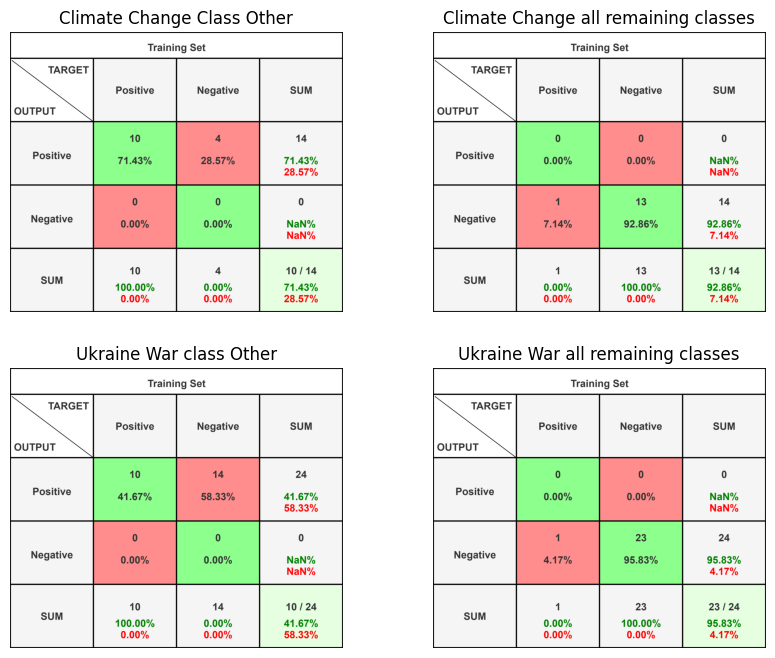

In [14]:
import matplotlib.pyplot as plt

images = ["cc_other.png", "cc_all.png", "ua_other.png", "ua_all.png"]
labels = [
    "Climate Change Class Other",
    "Climate Change all remaining classes",
    "Ukraine War class Other",
    "Ukraine War all remaining classes",
]
img_base_path = "../../info/screens/"
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i, (img_name, label) in enumerate(zip(images, labels)):
    row = i // 2
    col = i % 2
    img_path = img_base_path + "/" + img_name
    img = plt.imread(img_path)
    ax[row, col].imshow(img)
    ax[row, col].axis("off")
    ax[row, col].set_title(label)
plt.show()

#### Climate Change

For Climate Change narratives, we received for class *Other* the following Confusion Matrix:
[[0, 4], [0, 10]]

Calculating the metrics for this specific class:
* Accuracy: 71,43 %
* Precision: 71,43 %
* Recall: 100%
* F1 Score: 83,33 %

For all other classes, we received the following equal Confusion Matrix:
[[13, 0], [1, 0]]
* Accuracy: 92,86 %
* Precision: 0 %
* Recall: 0%
* F1 Score: 0 %


#### Ukraine War

For Ukraine War narratives, we received for class *Other* the following Confusion Matrix:
[[0, 14], [0, 10]]

Calculating the metrics for this specific class:
* Accuracy: 41,7 %
* Precision: 41,7 %
* Recall: 100%
* F1 Score: 58,8%

For all other classes, we received the following equal Confusion Matrix:
[[23, 0], [1, 0]]
* Accuracy: 95,8%
* Precision: 0%
* Recall: 0%
* F1 Score: 0%


For both approaches, we can see that all classes except of *Other* have no counts for *True Positives*, but a very high count for *True Negatives*. On the hand, we have the class *Other*, where all samples of class *Other* are classified correctly as *Other*, but still we have almost as many or even more narratives that were classified as *Other*, although they had a different class.

From those unequally distributed results we see that BERTs' prediction performance is best for class *Other* and no other class.

An issue that could cause that, can be a data imbalance. The class *Other* occurs most frequently in the dataset. From that, the model could have learned to predict especially this class mostly accurately, while it fails for all other classes.

## Possible solutions
Although we have used stratification to receive a better distribution of all classes, there are still some solutions that we should consider in the next part.

Apperently, the class *Other* is overrepresented in the data set. Since we only had less than 200 narratives available, one possible solution to improve the predictions is to use more data.
In the context of this task we also have narratives in other languages available that we can use to handle the imbalance.Having more data.

The issue could also be that  the class labeling was not carried out cleanly, so that we have the broad class *Other*, where most of the narratives belong to. Specifying the classes more accurate could help to balance the dataset.





## Qualitative Analysis

While finishing up our project, we accidentally deleted one of the result runs from our BERT model. Because of this, we can’t reproduce the predictions the model originally made, which were the basis for this qualitative analysis.

This notebook contains our qualitative analysis, and all the outputs are already included in the markdown and code cells exactly as they were when we first ran it. Thus, rerunning the notebook is not possible!

Since we had the freedom to choose the format for this analysis, we think this shouldn’t be a big issue as long as the outputs are left as they are.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from trainer import train_bert, prepare_data
from model import predict
from tqdm import tqdm

base_path = os.path.dirname(os.path.abspath(os.getcwd()))
label_directory = os.path.join(
    base_path, "models", "bert_20250113", "label_mapping.json"
)
input_file_full = os.path.join(base_path, "../predicted_dataframe.csv")
dataset = pd.read_csv(input_file_full)

C:\Users\asus9\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
texts, labels, label_mapping = prepare_data(dataset)
print(f"Sample text: {texts[:3]}")
print(f"Sample label: {labels[:3]}")

training_results = train_bert(dataset, base_path)
print(f"Training Results: {training_results}")

Sample text: ["['bill', 'gate', 'say', 'solution', 'climate', 'change', 'ok', 'four', 'private', 'jet', 'bill', 'gate', 'right', 'fly', 'around', 'world', 'private', 'jet', 'normal', 'person', 'force', 'live', 'minute', 'city', 'without', 'freedom', 'travel', 'accord', 'bill', 'gate', 'tell', 'bbc', 'much', 'anybody', 'else', 'fight', 'climate', 'change', 'gate', 'claim', 'continue', 'spend', 'billion', 'dollar', 'climate', 'change', 'activism', 'carbon', 'footprint', 'issue', 'sign', 'get', 'unfiltered', 'news', 'deliver', 'straight', 'inbox', 'unsubscribe', 'time', 'subscribing', 'agree', 'term', 'use', 'stay', 'home', 'come', 'kenya', 'learn', 'farming', 'malaria', 'gate', 'say', 'interview', 'amol', 'rajan', 'comfortable', 'idea', 'part', 'problem', 'pay', 'offset', 'also', 'billion', 'breakthrough', 'energy', 'group', 'spending', 'part', 'solution', 'gate', 'add', 'watch', 'early', 'year', 'gate', 'fly', 'around', 'australia', 'board', 'million', 'dollar', 'luxury', 'private', 'je

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sergejs (sergejs-tu-wien). Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

In [4]:
tqdm.pandas()
model_path = os.path.join(base_path, "models\bert_20250113")


# Preparing predictions
def classify_row(row):
    try:
        predicted_label, _ = predict(row["tokens_normalized"], model_path)
        return predicted_label
    except Exception as e:
        print(f"Error for row {row.name}: {e}")
        return None


# Predicting
dataset["predicted_narrative"] = dataset.progress_apply(classify_row, axis=1)
dataset.to_csv(os.path.join(base_path, "predicted_dataframe.csv"), index=False)

  0%|          | 0/1694 [00:00<?, ?it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 0: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 2: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 3: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 4: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 5: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 6: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 7: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 8: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 9: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 10: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 11: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 12: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 13: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 14: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 15: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 16: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 17: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 18: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 19: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 20: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  1%|▏         | 22/1694 [00:00<00:07, 213.72it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 21: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 22: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 23: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 24: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 25: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 26: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 27: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 28: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 29: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 30: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 31: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 32: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 33: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 34: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 35: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 36: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 37: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 38: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 39: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 40: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 41: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 42: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 43: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  3%|▎         | 45/1694 [00:00<00:07, 218.94it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 44: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 45: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 46: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 47: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 48: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 49: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 50: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 51: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 52: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 53: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 54: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 55: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 56: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 57: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 58: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 59: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 60: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 61: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 62: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 63: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 64: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 65: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  4%|▍         | 67/1694 [00:00<00:07, 215.40it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 66: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 67: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 68: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 69: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 70: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 71: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 72: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 73: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 74: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 75: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 76: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 77: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 78: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 79: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 80: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 81: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 82: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 83: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 84: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 85: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 86: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 87: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  5%|▌         | 89/1694 [00:00<00:07, 211.40it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 88: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 89: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 90: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 91: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 92: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 93: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 94: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 95: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 96: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 97: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 98: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 99: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 100: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 101: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 102: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 103: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 104: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 105: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 106: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 107: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 108: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 109: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  7%|▋         | 111/1694 [00:00<00:07, 210.54it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 110: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 111: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 112: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 113: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 114: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 115: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 116: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 117: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 118: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 119: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 120: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 121: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 122: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 123: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 124: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 125: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 126: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 127: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 128: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 129: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 130: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 131: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  8%|▊         | 133/1694 [00:00<00:07, 208.09it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 132: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 133: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 134: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 135: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 136: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 137: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 138: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 139: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 140: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 141: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 142: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 143: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 144: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 145: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 146: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 147: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 148: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 149: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 150: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 151: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 152: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


  9%|▉         | 154/1694 [00:00<00:07, 196.64it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 153: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 154: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 155: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 156: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 157: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 158: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 159: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 160: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 161: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 162: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 163: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 164: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 165: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 166: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 167: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 168: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 169: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 170: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 171: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 172: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 10%|█         | 174/1694 [00:00<00:08, 186.72it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 173: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 174: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 175: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 176: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 177: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 178: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 179: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 180: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 181: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 182: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 183: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 184: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 185: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 186: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 187: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 188: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 189: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 190: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 191: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 192: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 193: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 12%|█▏        | 195/1694 [00:00<00:07, 191.59it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 194: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 195: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 196: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 197: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 198: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 199: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 200: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 201: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 202: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 203: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 204: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 205: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 206: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 207: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 208: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 209: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 210: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 211: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 212: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 213: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 214: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 215: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 216: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 217: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 13%|█▎        | 219/1694 [00:01<00:07, 203.74it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 218: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 219: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 220: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 221: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 222: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 223: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 224: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 225: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 226: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 227: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 228: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 229: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 230: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 231: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 232: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 233: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 234: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 235: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 236: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 237: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 238: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 14%|█▍        | 240/1694 [00:01<00:07, 204.11it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 239: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 240: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 241: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 242: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 243: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 244: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 245: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 246: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 247: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 248: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 249: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 250: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 251: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 252: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 253: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 254: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 255: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 256: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 257: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 258: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 259: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 260: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 261: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 16%|█▌        | 263/1694 [00:01<00:06, 210.04it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 262: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 263: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 264: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 265: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 266: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 267: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 268: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 269: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 270: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 271: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 272: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 273: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 274: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 275: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 276: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 277: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 278: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 279: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 280: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 281: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 282: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 283: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 284: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 285: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 17%|█▋        | 287/1694 [00:01<00:06, 217.67it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 286: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 287: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 288: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 289: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 290: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 291: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 292: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 293: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 294: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 295: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 296: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 297: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 298: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 299: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 300: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 301: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 302: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 303: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 304: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 305: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 306: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 307: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 308: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 309: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 18%|█▊        | 311/1694 [00:01<00:06, 222.25it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 310: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 311: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 312: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 313: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 314: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 315: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 316: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 317: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 318: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 319: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 320: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 321: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 322: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 323: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 324: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 325: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 326: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 327: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 328: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 329: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 330: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 331: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 332: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 20%|█▉        | 334/1694 [00:01<00:06, 221.88it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 333: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 334: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 335: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 336: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 337: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 338: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 339: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 340: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 341: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 342: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 343: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 344: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 345: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 346: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 347: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 348: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 349: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 350: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 351: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 352: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 353: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 354: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 355: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 356: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 21%|██        | 358/1694 [00:01<00:05, 226.73it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 357: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 358: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 359: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 360: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 361: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 362: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 363: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 364: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 365: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 366: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 367: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 368: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 369: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 370: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 371: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 372: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 373: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 374: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 375: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 376: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 377: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 378: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 379: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 380: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 381: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 382: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 23%|██▎       | 384/1694 [00:01<00:05, 234.47it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 383: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 384: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 385: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 386: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 387: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 388: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 389: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 390: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 391: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 392: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 393: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 394: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 395: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 396: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 397: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 398: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 399: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 400: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 401: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 402: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 403: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 404: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 405: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 406: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 407: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 24%|██▍       | 409/1694 [00:01<00:05, 236.36it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 408: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 409: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 410: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 411: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 412: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 413: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 414: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 415: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 416: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 417: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 418: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 419: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 420: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 421: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 422: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 423: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 424: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 425: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 426: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 427: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 428: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 429: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 430: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 431: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 26%|██▌       | 433/1694 [00:02<00:05, 221.59it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 432: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 433: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 434: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 435: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 436: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 437: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 438: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 439: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 440: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 441: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 442: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 443: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 444: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 445: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 446: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 447: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 448: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 449: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 450: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 451: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 452: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 453: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 454: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 27%|██▋       | 456/1694 [00:02<00:05, 218.18it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 455: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 456: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 457: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 458: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 459: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 460: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 461: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 462: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 463: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 464: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 465: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 466: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 467: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 468: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 469: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 470: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 471: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 472: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 473: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 474: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 475: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 476: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 28%|██▊       | 478/1694 [00:02<00:05, 217.86it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 477: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 478: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 479: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 480: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 481: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 482: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 483: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 484: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 485: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 486: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 487: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 488: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 489: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 490: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 491: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 492: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 493: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 494: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 495: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 496: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 497: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 498: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 499: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 500: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 30%|██▉       | 502/1694 [00:02<00:05, 222.69it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 501: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 502: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 503: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 504: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 505: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 506: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 507: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 508: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 509: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 510: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 511: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 512: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 513: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 514: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 515: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 516: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 517: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 518: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 519: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 520: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 521: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 522: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 523: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 31%|███       | 525/1694 [00:02<00:05, 217.93it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 524: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 525: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 526: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 527: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 528: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 529: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 530: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 531: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 532: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 533: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 534: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 535: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 536: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 537: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 538: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 539: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 540: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 541: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 542: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 543: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 544: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 545: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 546: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 32%|███▏      | 548/1694 [00:02<00:05, 219.73it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 547: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 548: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 549: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 550: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 551: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 552: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 553: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 554: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 555: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 556: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 557: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 558: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 559: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 560: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 561: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 562: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 563: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 564: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 565: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 566: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 567: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 568: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 569: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 570: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 571: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 34%|███▍      | 573/1694 [00:02<00:04, 228.19it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 572: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 573: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 574: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 575: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 576: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 577: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 578: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 579: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 580: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 581: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 582: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 583: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 584: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 585: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 586: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 587: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 588: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 589: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 590: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 591: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 592: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 593: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 594: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 595: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 596: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 597: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 35%|███▌      | 599/1694 [00:02<00:04, 234.89it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 598: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 599: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 600: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 601: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 602: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 603: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 604: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 605: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 606: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 607: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 608: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 609: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 610: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 611: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 612: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 613: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 614: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 615: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 616: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 617: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 618: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 619: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 620: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 621: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 37%|███▋      | 623/1694 [00:02<00:04, 231.77it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 622: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 623: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 624: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 625: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 626: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 627: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 628: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 629: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 630: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 631: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 632: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 633: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 634: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 635: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 636: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 637: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 638: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 639: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 640: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 641: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 642: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 643: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 644: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 645: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 38%|███▊      | 647/1694 [00:02<00:04, 219.47it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 646: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 647: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 648: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 649: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 650: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 651: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 652: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 653: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 654: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 655: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 656: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 657: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 658: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 659: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 660: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 661: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 662: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 663: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 664: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 665: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 666: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 667: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 668: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 40%|███▉      | 670/1694 [00:03<00:04, 217.69it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 669: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 670: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 671: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 672: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 673: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 674: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 675: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 676: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 677: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 678: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 679: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 680: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 681: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 682: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 683: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 684: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 685: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 686: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 687: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 688: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 689: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 690: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 691: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 692: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 41%|████      | 694/1694 [00:03<00:04, 223.25it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 693: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 694: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 695: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 696: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 697: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 698: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 699: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 700: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 701: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 702: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 703: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 704: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 705: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 706: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 707: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 708: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 709: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 710: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 711: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 712: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 713: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 714: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 715: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 716: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 717: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 718: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 43%|████▎     | 720/1694 [00:03<00:04, 232.82it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 719: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 720: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 721: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 722: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 723: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 724: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 725: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 726: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 727: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 728: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 729: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 730: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 731: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 732: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 733: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 734: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 735: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 736: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 737: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 738: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 739: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 740: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 741: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 742: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 44%|████▍     | 744/1694 [00:03<00:04, 233.35it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 743: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 744: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 745: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 746: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 747: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 748: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 749: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 750: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 751: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 752: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 753: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 754: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 755: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 756: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 757: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 758: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 759: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 760: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 761: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 762: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 763: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 764: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 765: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 766: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 767: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 768: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 769: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 46%|████▌     | 771/1694 [00:03<00:03, 243.98it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 770: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 771: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 772: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 773: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 774: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 775: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 776: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 777: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 778: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 779: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 780: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 781: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 782: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 783: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 784: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 785: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 786: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 787: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 788: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 789: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 790: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 791: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 792: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 793: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 794: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 795: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 47%|████▋     | 797/1694 [00:03<00:03, 247.67it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 796: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 797: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 798: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 799: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 800: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 801: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 802: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 803: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 804: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 805: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 806: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 807: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 808: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 809: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 810: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 811: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 812: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 813: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 814: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 815: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 816: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 817: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 818: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 819: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 820: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 49%|████▊     | 822/1694 [00:03<00:03, 246.56it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 821: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 822: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 823: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 824: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 825: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 826: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 827: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 828: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 829: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 830: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 831: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 832: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 833: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 834: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 835: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 836: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 837: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 838: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 839: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 840: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 841: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 842: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 843: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 844: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 845: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 846: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 847: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 848: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 50%|█████     | 850/1694 [00:03<00:03, 254.00it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 849: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 850: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 851: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 852: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 853: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 854: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 855: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 856: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 857: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 858: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 859: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 860: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 861: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 862: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 863: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 864: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 865: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 866: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 867: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 868: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 869: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 870: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 871: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 872: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 873: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 874: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 875: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 876: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 877: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 52%|█████▏    | 879/1694 [00:03<00:03, 264.57it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 878: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 879: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 880: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 881: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 882: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 883: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 884: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 885: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 886: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 887: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 888: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 889: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 890: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 891: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 892: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 893: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 894: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 895: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 896: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 897: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 898: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 899: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 900: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 901: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 902: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 903: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 904: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 53%|█████▎    | 906/1694 [00:04<00:02, 265.41it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 905: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 906: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 907: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 908: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 909: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 910: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 911: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 912: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 913: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 914: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 915: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 916: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 917: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 918: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 919: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 920: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 921: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 922: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 923: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 924: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 925: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 926: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 927: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 928: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 929: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 930: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 931: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 932: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 933: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 55%|█████▌    | 935/1694 [00:04<00:02, 270.19it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 934: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 935: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 936: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 937: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 938: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 939: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 940: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 941: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 942: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 943: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 944: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 945: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 946: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 947: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 948: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 949: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 950: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 951: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 952: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 953: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 954: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 955: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 956: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 957: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 958: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 959: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 960: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 961: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 57%|█████▋    | 963/1694 [00:04<00:02, 265.00it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 962: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 963: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 964: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 965: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 966: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 967: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 968: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 969: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 970: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 971: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 972: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 973: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 974: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 975: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 976: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 977: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 978: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 979: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 980: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 981: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 982: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 983: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 984: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 985: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 986: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 987: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 988: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 58%|█████▊    | 990/1694 [00:04<00:02, 266.26it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 989: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 990: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 991: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 992: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 993: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 994: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 995: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 996: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 997: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 998: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 999: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1000: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1001: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1002: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1003: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1004: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1005: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1006: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1007: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1008: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1009: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1010: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1011: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1012: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1013: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1014: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1015: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1016: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1017: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 60%|██████    | 1019/1694 [00:04<00:02, 272.53it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1018: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1019: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1020: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1021: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1022: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1023: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1024: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1025: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1026: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1027: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1028: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1029: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1030: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1031: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1032: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1033: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1034: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1035: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1036: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1037: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1038: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1039: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1040: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1041: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1042: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1043: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1044: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1045: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1046: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 62%|██████▏   | 1048/1694 [00:04<00:02, 275.27it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1047: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1048: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1049: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1050: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1051: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1052: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1053: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1054: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1055: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1056: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1057: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1058: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1059: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1060: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1061: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1062: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1063: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1064: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1065: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1066: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1067: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1068: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1069: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1070: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1071: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1072: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1073: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1074: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 64%|██████▎   | 1076/1694 [00:04<00:02, 273.08it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1075: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1076: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1077: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1078: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1079: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1080: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1081: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1082: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1083: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1084: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1085: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1086: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1087: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1088: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1089: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1090: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1091: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1092: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1093: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1094: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1095: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1096: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1097: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1098: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1099: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1100: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1101: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1102: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 65%|██████▌   | 1104/1694 [00:04<00:02, 265.67it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1103: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1104: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1105: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1106: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1107: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1108: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1109: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1110: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1111: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1112: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1113: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1114: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1115: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1116: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1117: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1118: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1119: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1120: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1121: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1122: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1123: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1124: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1125: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1126: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1127: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1128: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1129: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 67%|██████▋   | 1131/1694 [00:04<00:02, 264.19it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1130: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1131: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1132: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1133: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1134: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1135: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1136: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1137: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1138: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1139: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1140: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1141: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1142: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1143: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1144: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1145: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1146: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1147: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1148: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1149: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1150: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1151: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1152: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1153: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1154: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1155: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1156: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1157: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1158: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 68%|██████▊   | 1160/1694 [00:04<00:01, 269.19it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1159: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1160: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1161: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1162: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1163: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1164: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1165: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1166: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1167: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1168: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1169: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1170: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1171: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1172: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1173: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1174: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1175: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1176: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1177: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1178: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1179: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1180: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1181: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1182: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1183: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1184: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1185: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 70%|███████   | 1187/1694 [00:05<00:01, 265.61it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1186: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1187: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1188: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1189: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1190: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1191: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1192: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1193: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1194: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1195: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1196: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1197: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1198: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1199: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1200: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1201: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1202: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1203: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1204: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1205: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1206: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1207: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1208: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1209: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1210: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1211: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1212: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1213: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1214: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 72%|███████▏  | 1216/1694 [00:05<00:01, 271.57it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1215: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1216: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1217: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1218: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1219: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1220: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1221: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1222: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1223: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1224: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1225: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1226: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1227: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1228: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1229: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1230: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1231: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1232: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1233: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1234: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1235: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1236: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1237: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1238: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1239: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1240: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1241: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1242: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 73%|███████▎  | 1244/1694 [00:05<00:01, 258.81it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1243: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1244: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1245: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1246: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1247: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1248: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1249: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1250: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1251: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1252: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1253: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1254: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1255: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1256: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1257: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1258: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1259: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1260: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1261: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1262: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1263: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1264: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1265: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1266: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1267: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1268: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1269: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1270: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 75%|███████▌  | 1272/1694 [00:05<00:01, 262.18it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1271: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1272: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1273: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1274: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1275: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1276: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1277: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1278: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1279: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1280: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1281: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1282: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1283: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1284: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1285: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1286: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1287: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1288: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1289: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1290: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1291: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1292: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1293: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1294: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1295: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1296: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1297: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1298: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 77%|███████▋  | 1300/1694 [00:05<00:01, 266.08it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1299: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1300: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1301: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1302: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1303: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1304: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1305: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1306: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1307: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1308: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1309: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1310: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1311: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1312: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1313: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1314: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1315: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1316: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1317: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1318: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1319: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1320: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1321: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1322: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1323: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1324: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1325: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1326: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1327: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 78%|███████▊  | 1329/1694 [00:05<00:01, 269.73it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1328: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1329: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1330: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1331: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1332: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1333: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1334: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1335: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1336: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1337: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1338: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1339: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1340: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1341: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1342: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1343: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1344: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1345: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1346: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1347: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1348: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1349: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1350: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1351: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1352: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1353: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1354: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1355: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 80%|████████  | 1357/1694 [00:05<00:01, 267.27it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1356: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1357: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1358: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1359: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1360: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1361: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1362: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1363: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1364: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1365: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1366: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1367: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1368: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1369: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1370: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1371: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1372: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1373: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1374: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1375: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1376: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1377: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1378: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1379: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1380: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1381: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1382: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1383: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1384: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 82%|████████▏ | 1386/1694 [00:05<00:01, 272.19it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1385: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1386: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1387: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1388: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1389: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1390: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1391: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1392: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1393: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1394: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1395: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1396: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1397: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1398: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1399: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1400: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1401: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1402: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1403: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1404: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1405: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1406: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1407: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1408: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1409: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1410: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1411: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1412: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 83%|████████▎ | 1414/1694 [00:05<00:01, 270.76it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1413: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1414: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1415: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1416: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1417: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1418: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1419: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1420: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1421: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1422: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1423: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1424: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1425: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1426: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1427: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1428: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1429: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1430: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1431: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1432: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1433: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1434: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1435: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1436: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1437: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1438: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1439: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1440: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 85%|████████▌ | 1442/1694 [00:06<00:00, 266.20it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1441: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1442: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1443: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1444: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1445: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1446: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1447: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1448: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1449: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1450: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1451: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1452: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1453: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1454: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1455: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1456: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1457: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1458: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1459: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1460: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1461: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1462: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1463: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1464: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1465: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1466: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1467: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1468: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 87%|████████▋ | 1470/1694 [00:06<00:00, 270.04it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1469: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1470: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1471: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1472: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1473: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1474: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1475: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1476: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1477: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1478: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1479: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1480: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1481: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1482: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1483: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1484: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1485: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1486: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1487: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1488: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1489: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1490: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1491: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1492: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1493: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1494: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1495: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1496: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 88%|████████▊ | 1498/1694 [00:06<00:00, 270.83it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1497: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1498: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1499: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1500: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1501: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1502: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1503: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1504: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1505: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1506: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1507: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1508: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1509: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1510: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1511: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1512: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1513: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1514: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1515: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1516: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1517: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1518: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1519: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1520: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1521: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1522: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1523: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1524: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 90%|█████████ | 1526/1694 [00:06<00:00, 272.16it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1525: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1526: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1527: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1528: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1529: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1530: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1531: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1532: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1533: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1534: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1535: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1536: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1537: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1538: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1539: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1540: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1541: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1542: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1543: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1544: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1545: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1546: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1547: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1548: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1549: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1550: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1551: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1552: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 92%|█████████▏| 1554/1694 [00:06<00:00, 273.24it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1553: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1554: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1555: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1556: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1557: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1558: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1559: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1560: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1561: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1562: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1563: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1564: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1565: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1566: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1567: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1568: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1569: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1570: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1571: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1572: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1573: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1574: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1575: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1576: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1577: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1578: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1579: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1580: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 93%|█████████▎| 1582/1694 [00:06<00:00, 274.35it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1581: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1582: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1583: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1584: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1585: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1586: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1587: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1588: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1589: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1590: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1591: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1592: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1593: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1594: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1595: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1596: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1597: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1598: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1599: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1600: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1601: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1602: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1603: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1604: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1605: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1606: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1607: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1608: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 95%|█████████▌| 1610/1694 [00:06<00:00, 273.78it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1609: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1610: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1611: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1612: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1613: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1614: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1615: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1616: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1617: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1618: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1619: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1620: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1621: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1622: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1623: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1624: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1625: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1626: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1627: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1628: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1629: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1630: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1631: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1632: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1633: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1634: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1635: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1636: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 97%|█████████▋| 1638/1694 [00:06<00:00, 270.62it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1637: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1638: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1639: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1640: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1641: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1642: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1643: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1644: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1645: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1646: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1647: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1648: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1649: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1650: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1651: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1652: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1653: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1654: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1655: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1656: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1657: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1658: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1659: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1660: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1661: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1662: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1663: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1664: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1665: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1666: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1667: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1668: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


 99%|█████████▊| 1670/1694 [00:06<00:00, 279.81it/s]Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1669: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1670: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1671: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1672: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1673: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1674: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1675: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1676: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1677: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1678: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1679: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1680: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1681: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1682: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1683: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1684: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1685: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1686: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1687: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1688: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1689: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1690: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1691: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1692: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error in prediction: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


Error for row 1693: Incorrect path_or_model_id: 'C:\Data Science\Module\Natural Language Processing\Backpropagandists\nlp_Backpropagandists_2024\code\dl_methods\models/bert_20250113'. Please provide either the path to a local folder or the repo_id of a model on the Hub.


100%|██████████| 1694/1694 [00:06<00:00, 244.68it/s]


In [9]:
dataset = pd.read_csv(os.path.join(base_path, "predicted_dataframe.csv"))
dataset.head()

filename language  \
0  EN_CC_100013.txt       EN   
1  EN_UA_300009.txt       EN   
2  EN_UA_300017.txt       EN   
3  EN_CC_100021.txt       EN   
4  EN_UA_300041.txt       EN   

                                             content topic  \
0  Bill Gates Says He Is ‘The Solution’ To Climat...    CC   
1  Russia: Clashes erupt in Bashkortostan as righ...    UA   
2  McDonald's to exit Russia, sell business in co...    UA   
3  Collaborative plans, innovation keys to circul...    CC   
4  Russia intends to supply light ‘Mountain’ tank...    UA   

                        narrative_subnarrative_pairs target_indices  \
0  [{'narrative': 'Criticism of climate movement'...           [14]   
1  [{'narrative': 'Other', 'subnarrative': 'Other'}]           [32]   
2  [{'narrative': 'Other', 'subnarrative': 'Other'}]           [32]   
3  [{'narrative': 'Other', 'subnarrative': 'Other'}]           [42]   
4  [{'narrative': 'Other', 'subnarrative': 'Other'}]           [32]   

                                              tokens  \
0  [['Bill', 'Gates', 'Says', 'He', 'Is', '‘', 'T...   
1  [['Russia', ':', 'Clashes', 'erupt', 'in', 'Ba...   
2  [['McDonald', "'s", 'to', 'exit', 'Russia', ',...   
3  [['Collaborative', 'plans', ',', 'innovation',...   
4  [['Russia', 'intends', 'to', 'supply', 'light'...   

                                   tokens_normalized  \
0  ['bill', 'gate', 'say', 'solution', 'climate',...   
1  ['russia', 'clash', 'erupt', 'bashkortostan', ...   
2  ['mcdonald', 'exit', 'russia', 'sell', 'busine...   
3  ['collaborative', 'plan', 'innovation', 'key',...   
4  ['russia', 'intend', 'supply', 'light', 'mount...   

                                      temp_narrative  \
0  {'narrative': 'Criticism of climate movement',...   
1    {'narrative': 'Other', 'subnarrative': 'Other'}   
2    {'narrative': 'Other', 'subnarrative': 'Other'}   
3    {'narrative': 'Other', 'subnarrative': 'Other'}   
4    {'narrative': 'Other', 'subnarrative': 'Other'}   

                               predicted_narrative  
0  {'narrative': 'Other', 'subnarrative': 'Other'}  
1  {'narrative': 'Other', 'subnarrative': 'Other'}  
2  {'narrative': 'Other', 'subnarrative': 'Other'}  
3  {'narrative': 'Other', 'subnarrative': 'Other'}  
4  {'narrative': 'Other', 'subnarrative': 'Other'}

Here, we will pick one class label and analyze why some articles are getting predicted and especially why most of
the news articles that are actually assigned to that class are not predicted to be in this class.

We will again choose one class for qualitative analysis which has at least one *True Positive* and some *False Negatives* in English and Russian both, that we can compare with each other.

### English

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

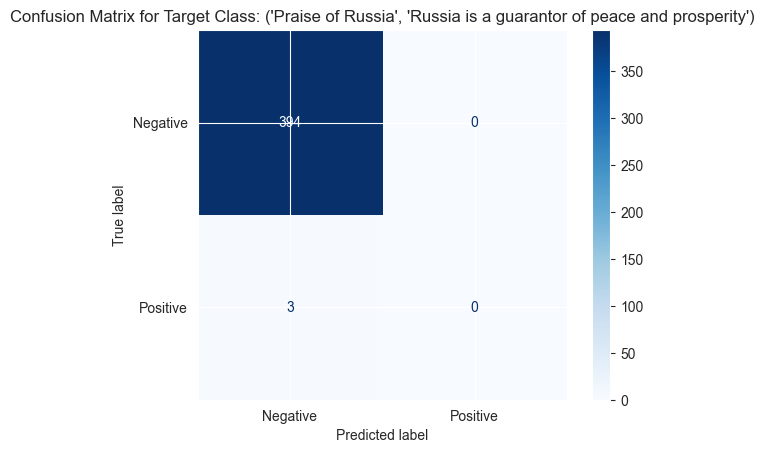

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

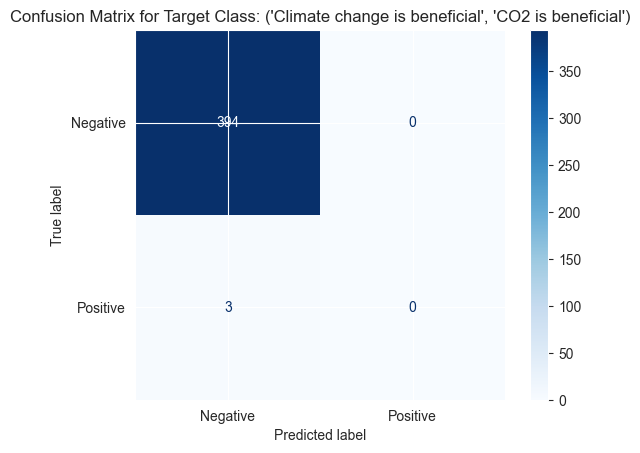

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

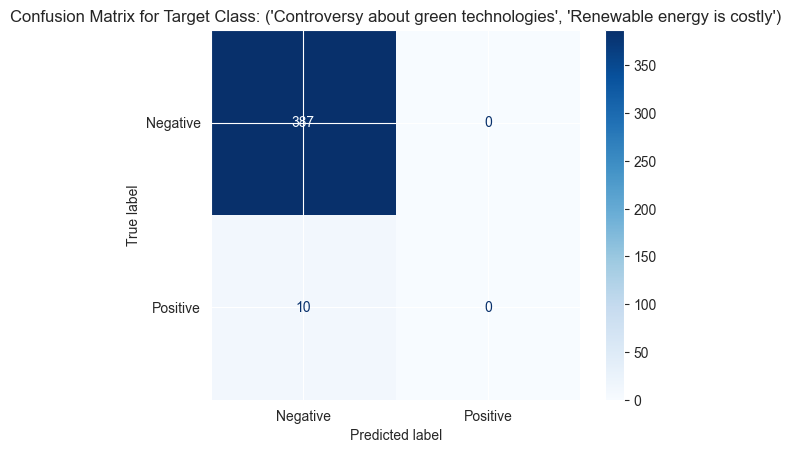

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

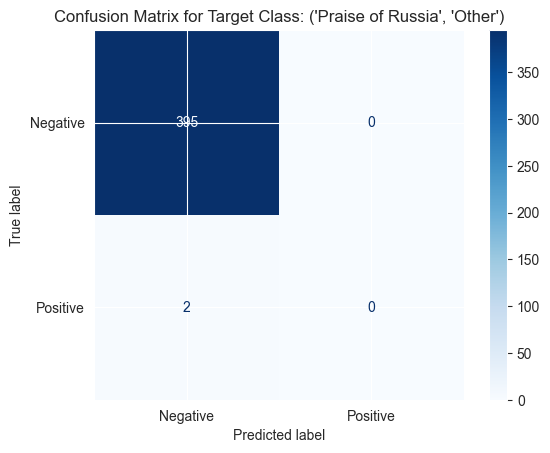

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

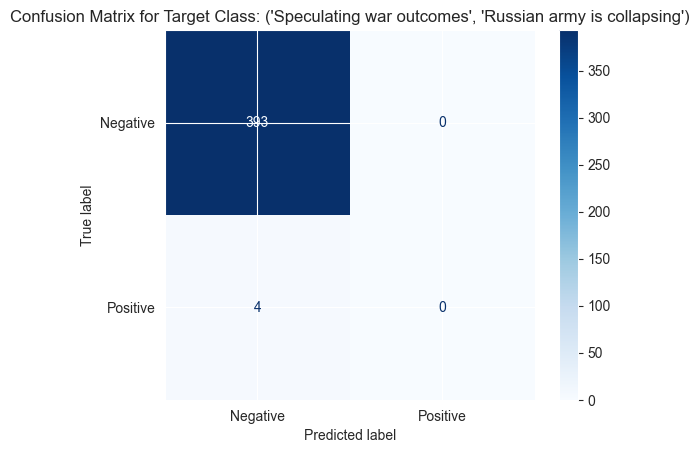

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

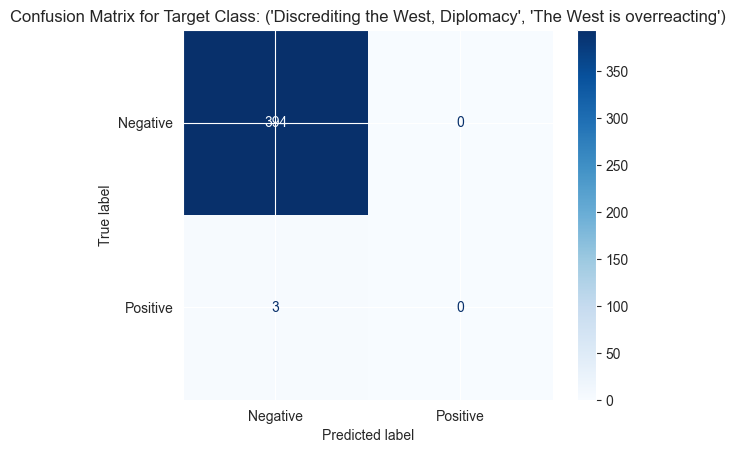

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

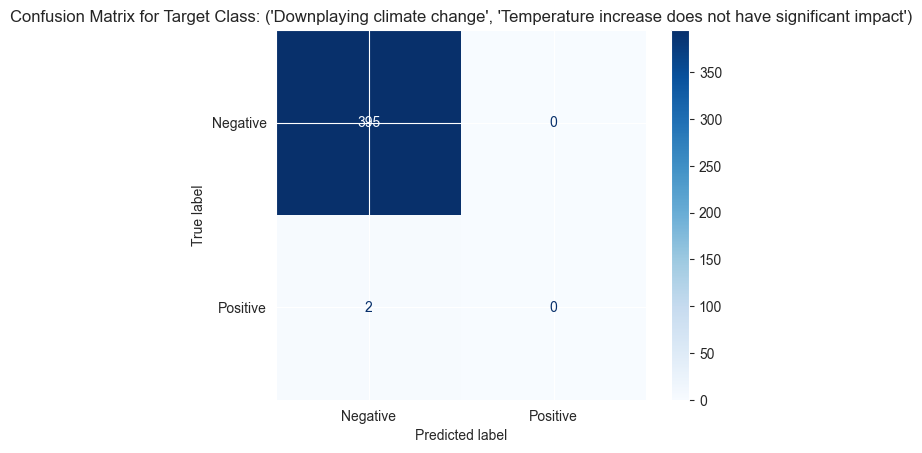

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

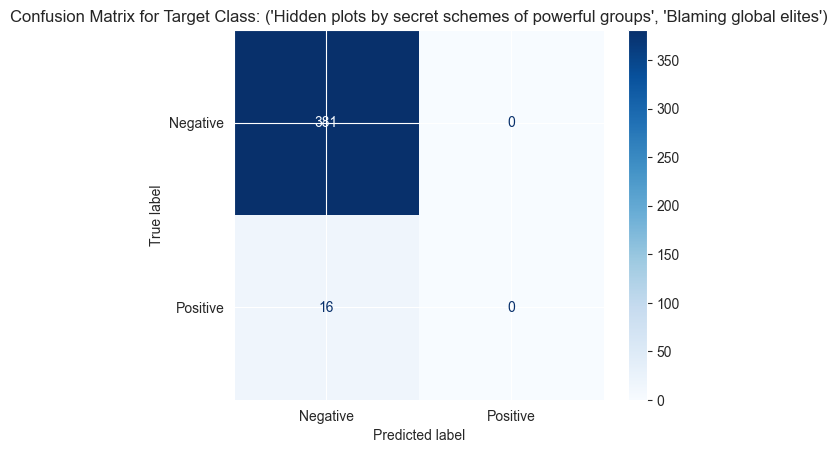

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

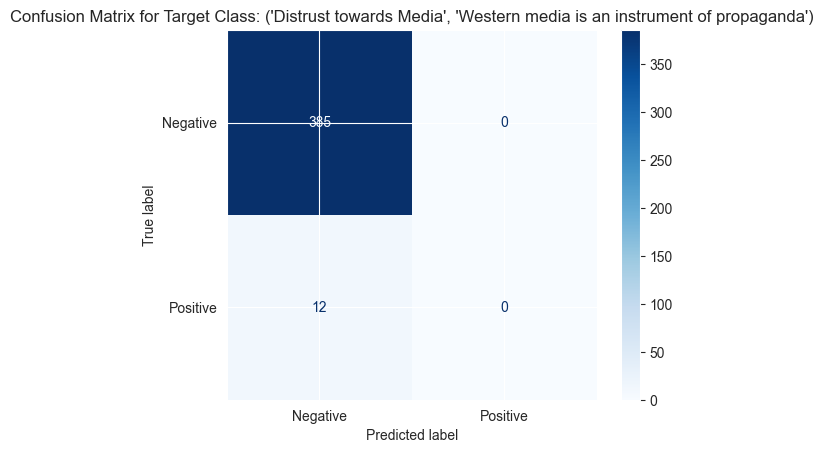

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

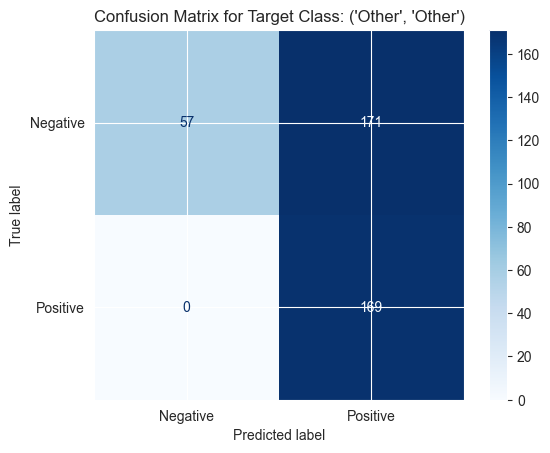

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

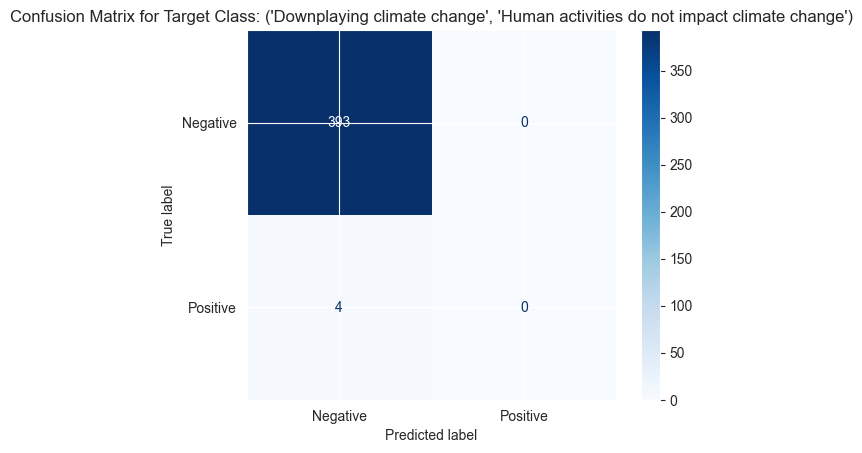

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

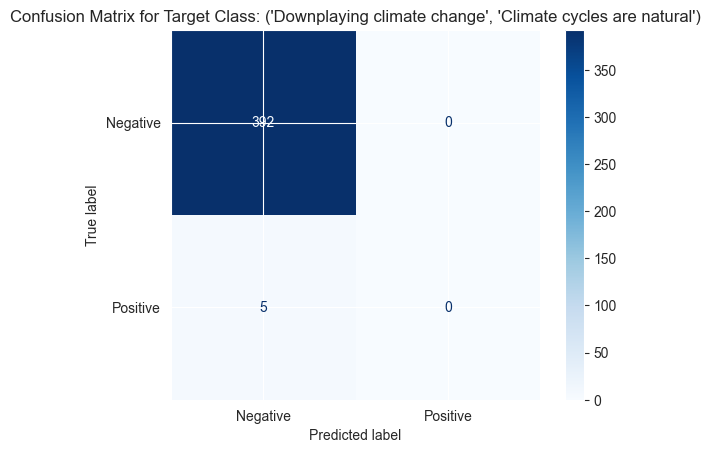

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

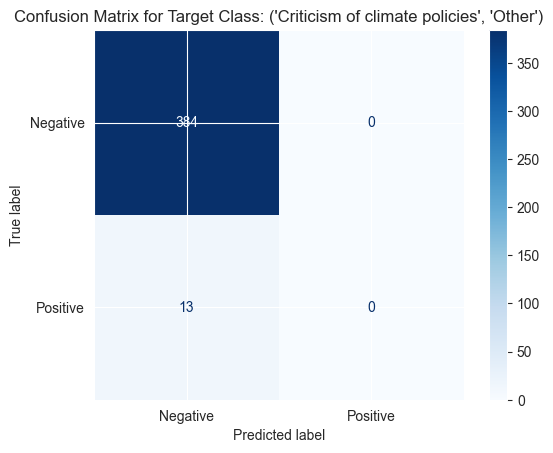

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

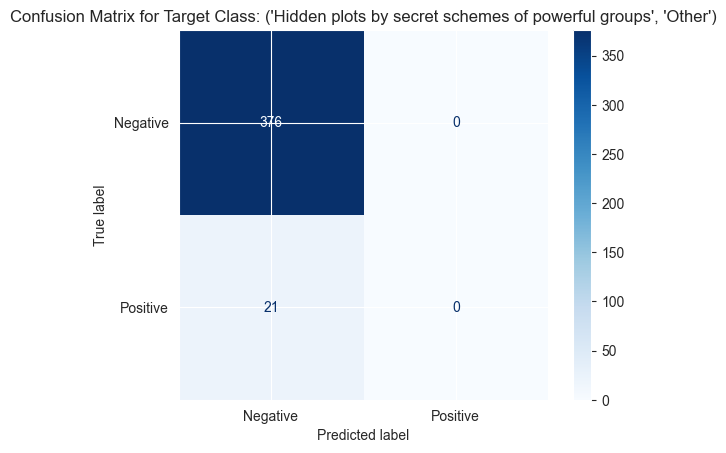

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

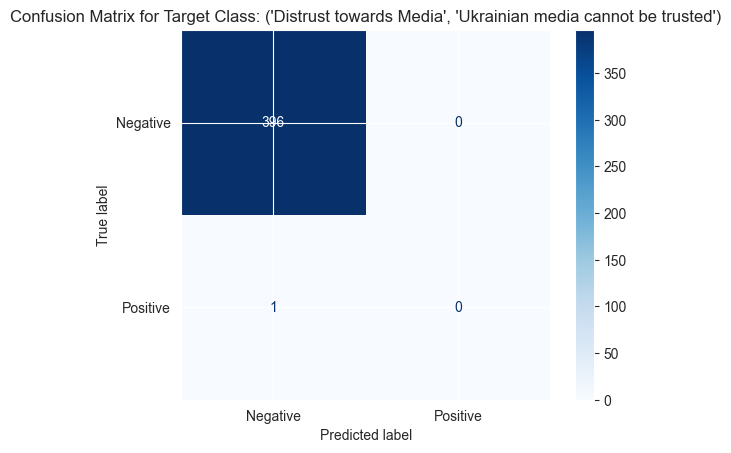

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

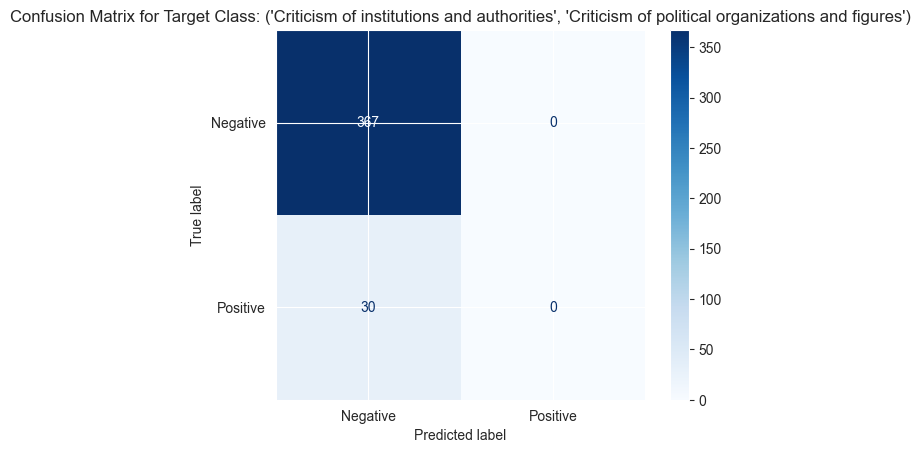

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

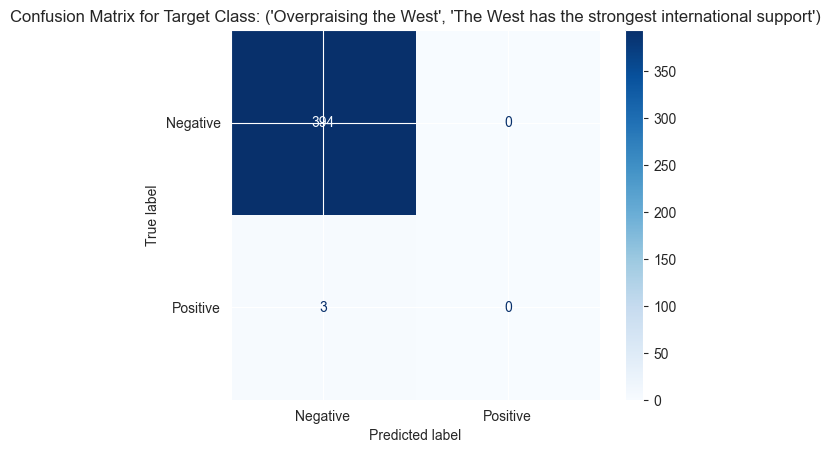

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

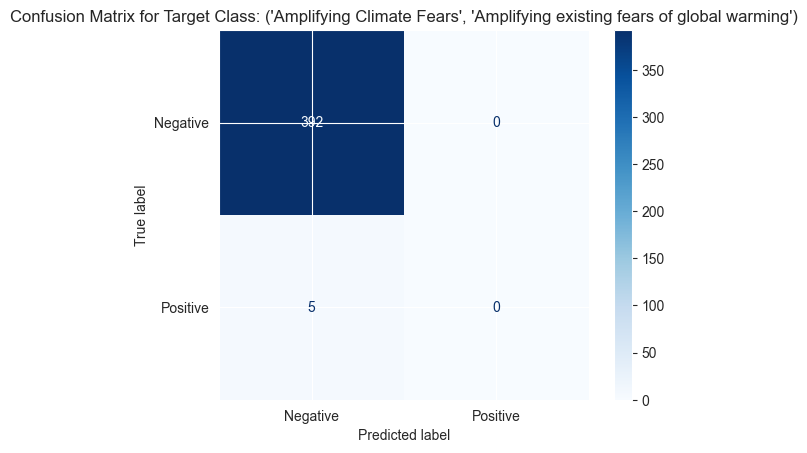

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

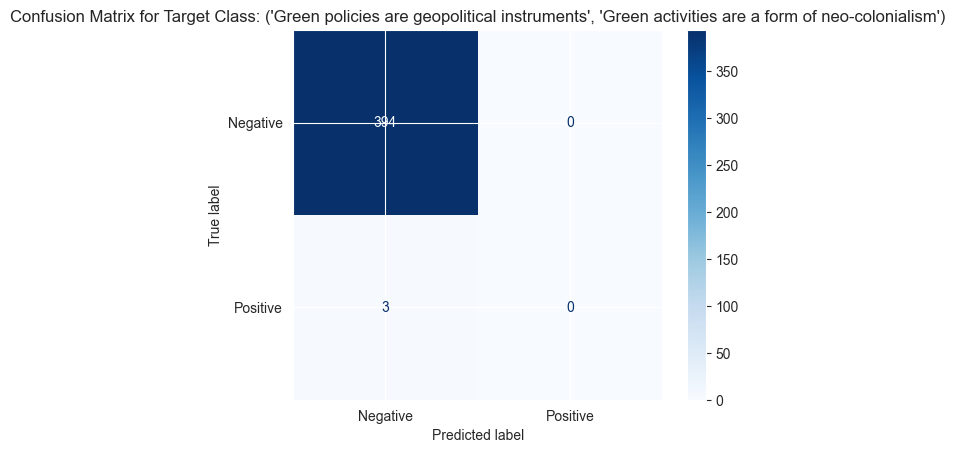

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

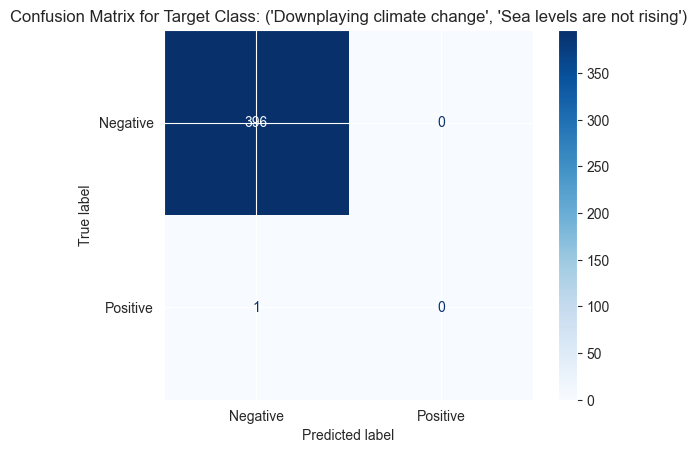

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

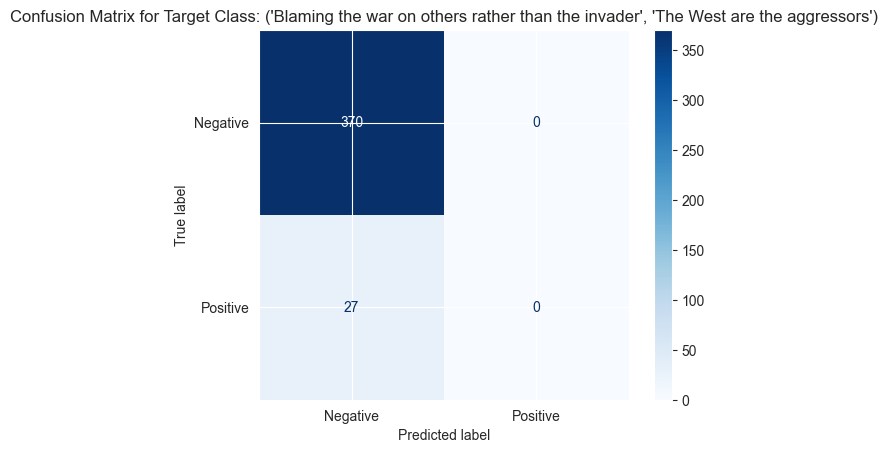

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

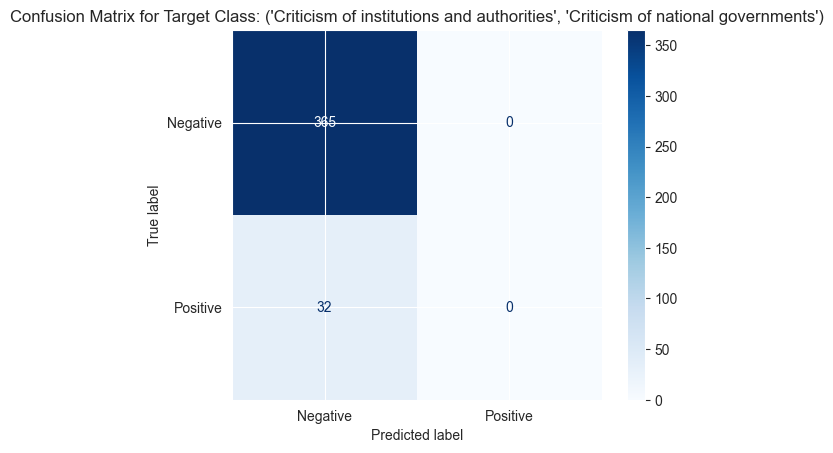

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

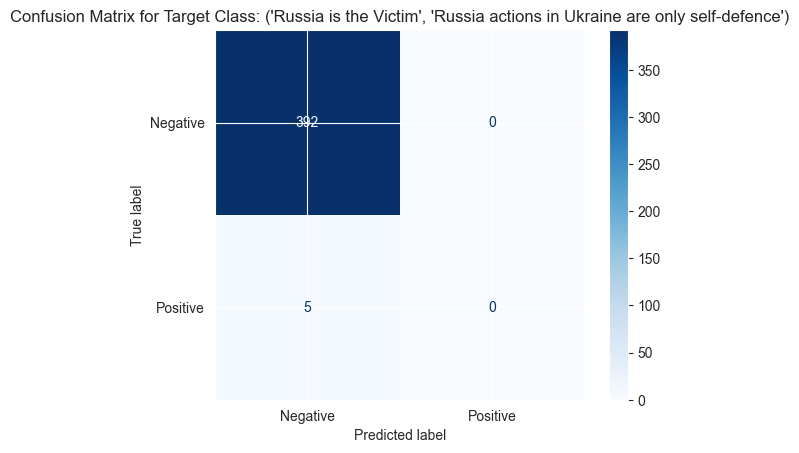

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

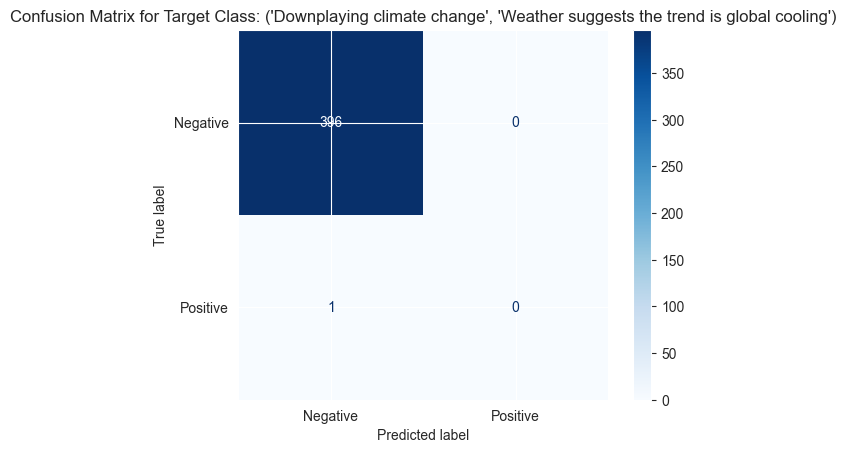

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

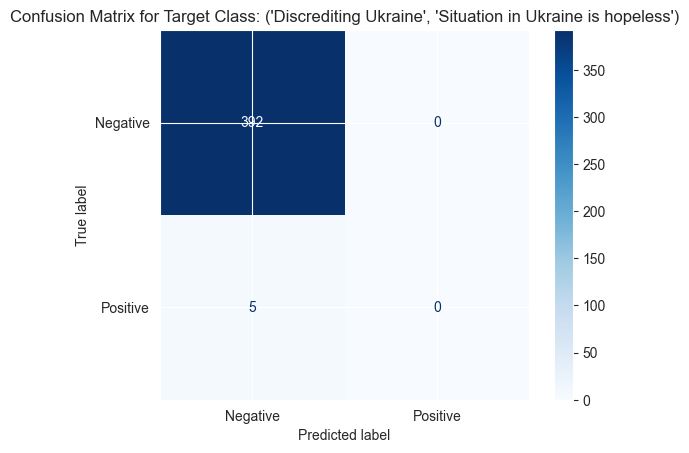

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

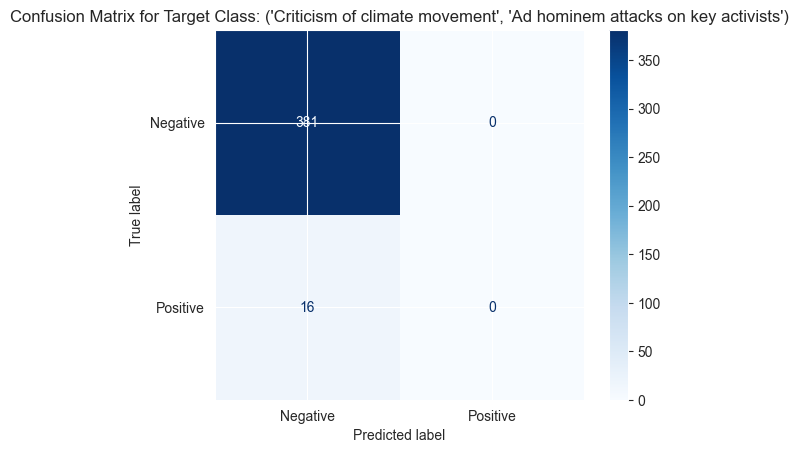

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

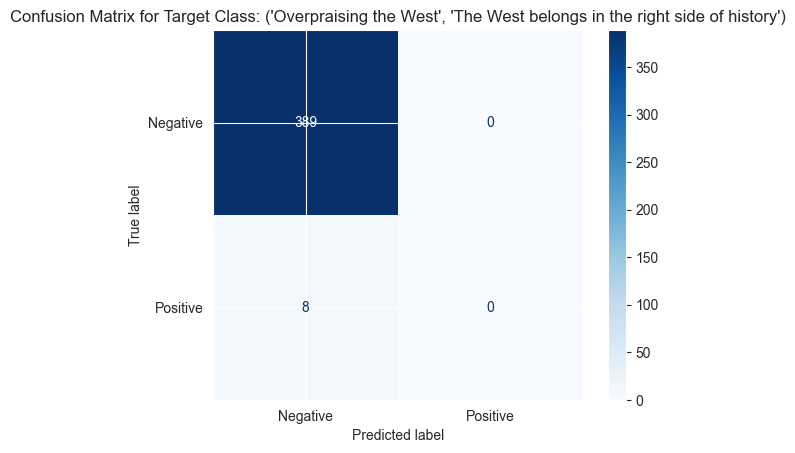

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

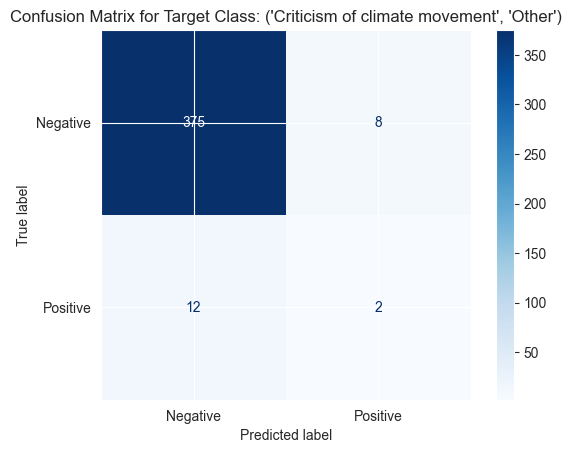

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

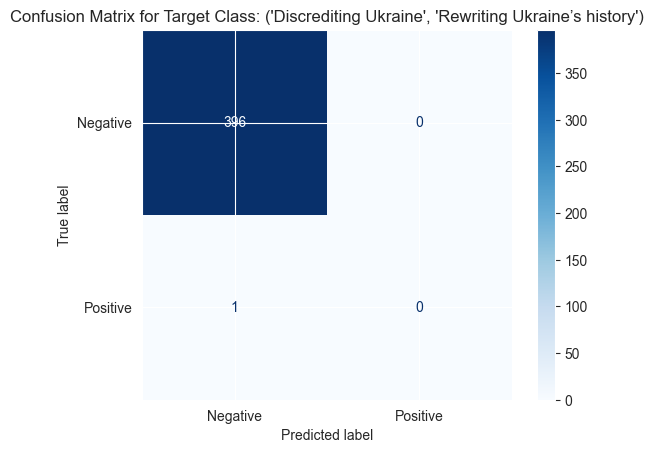

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

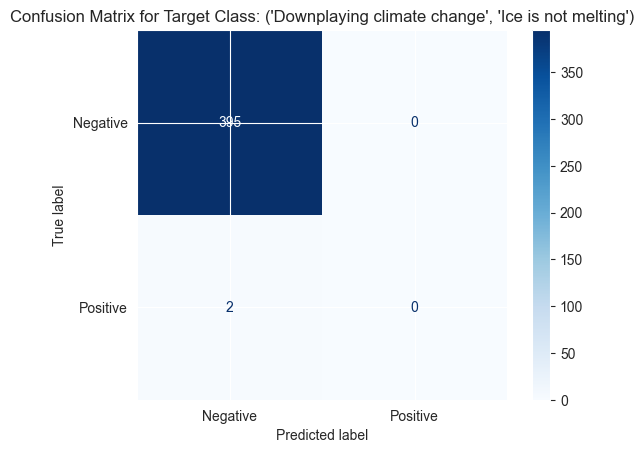

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

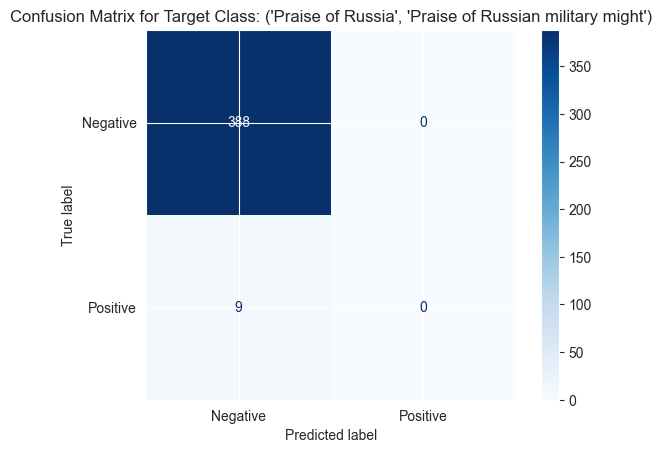

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

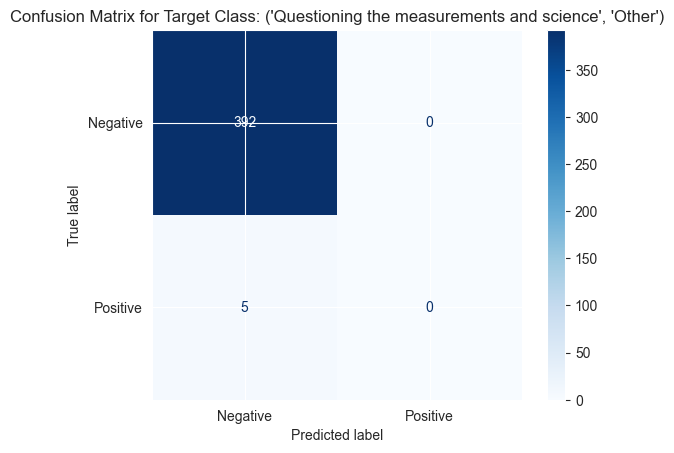

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

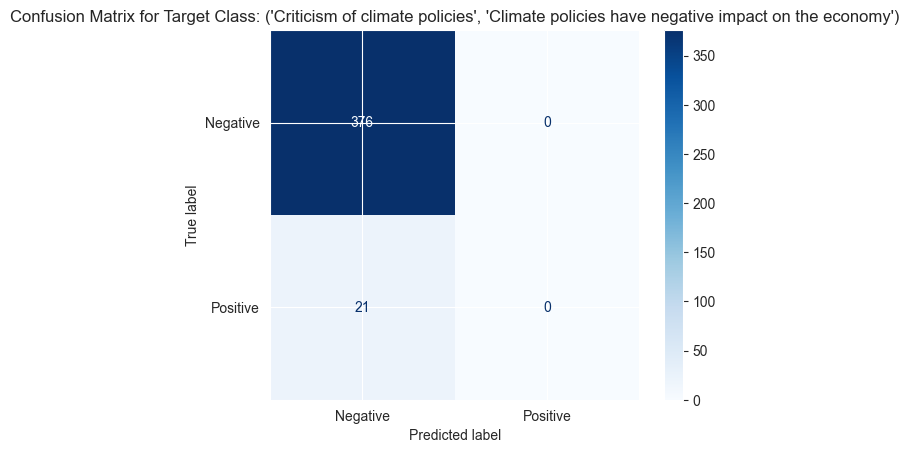

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

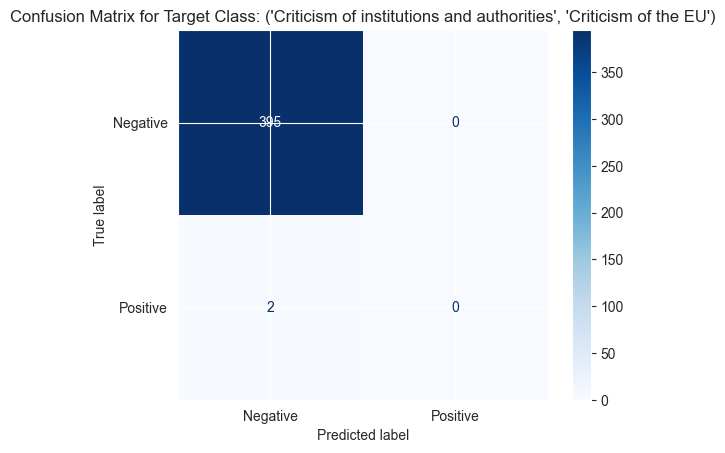

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

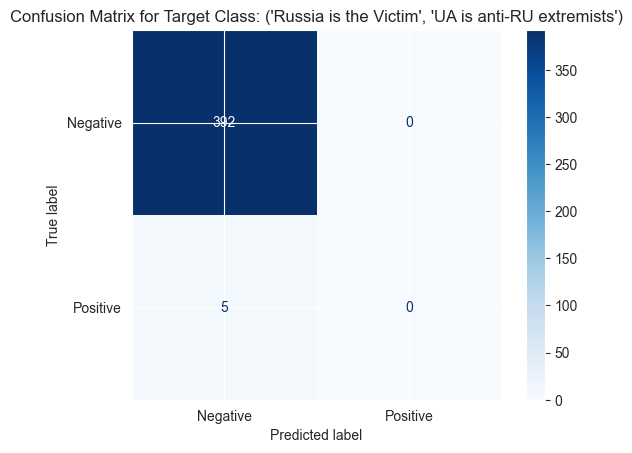

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

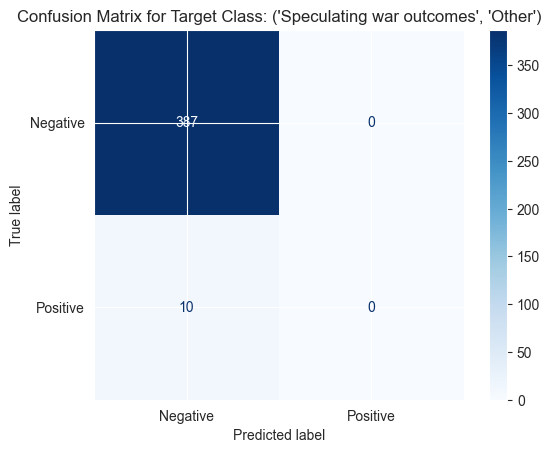

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

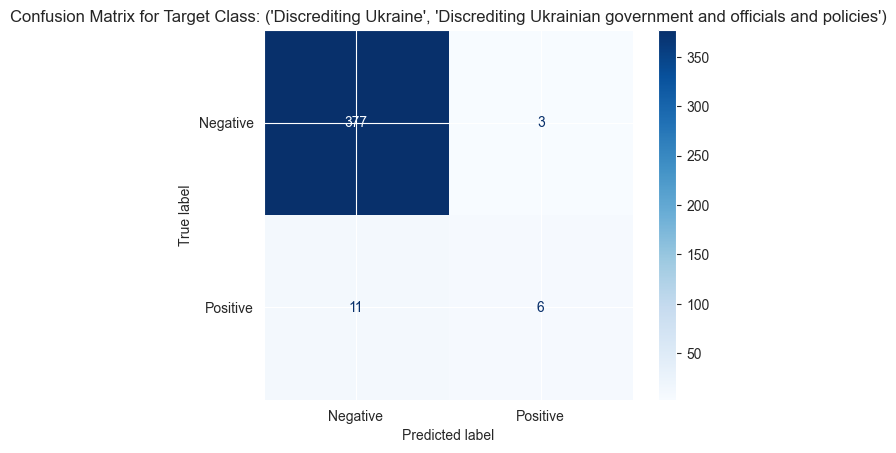

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

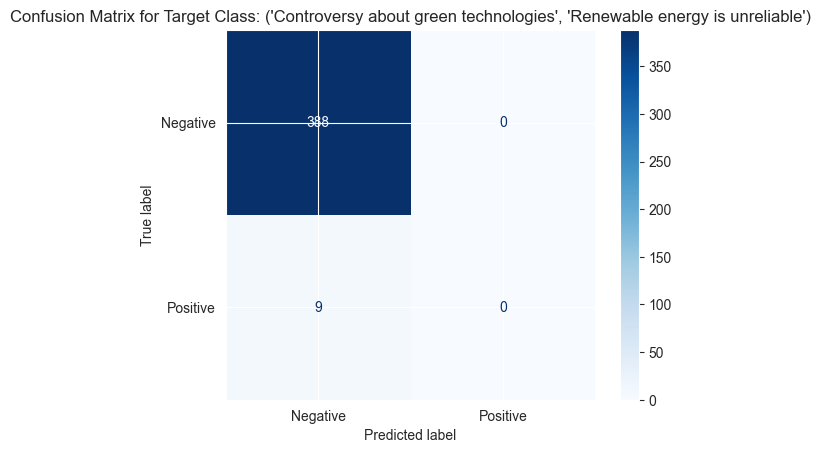

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

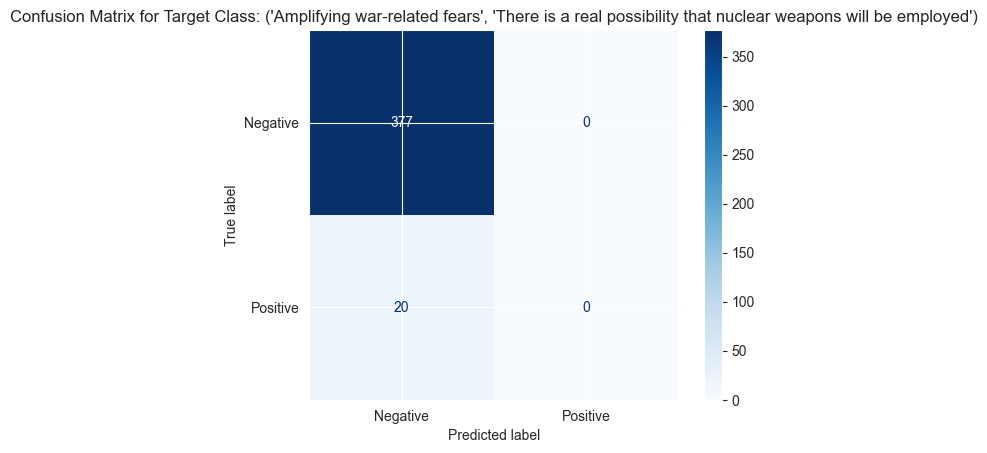

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

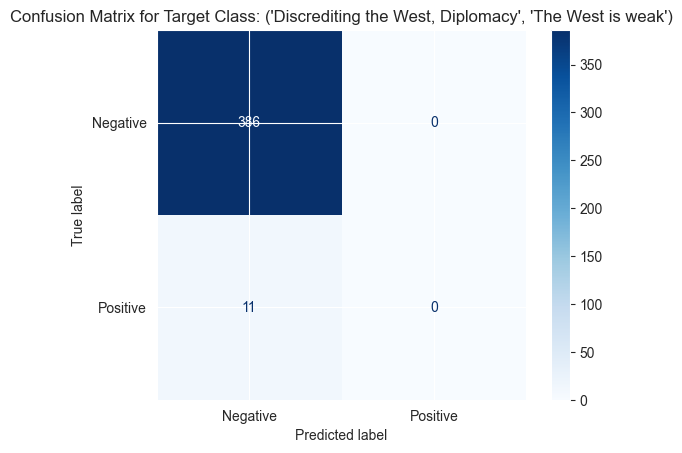

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

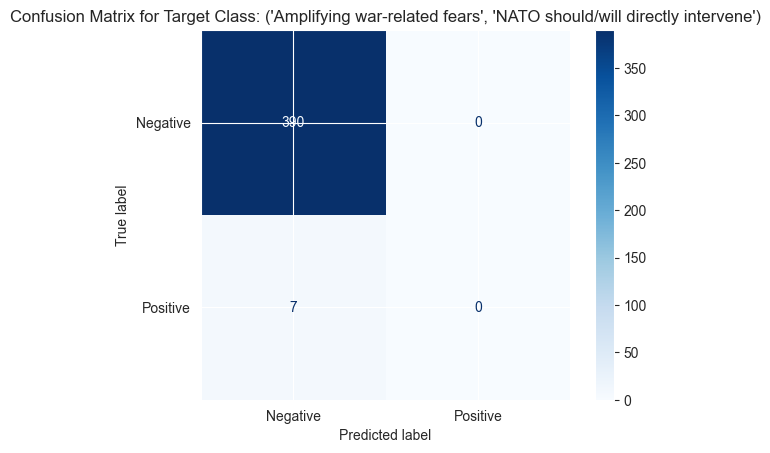

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

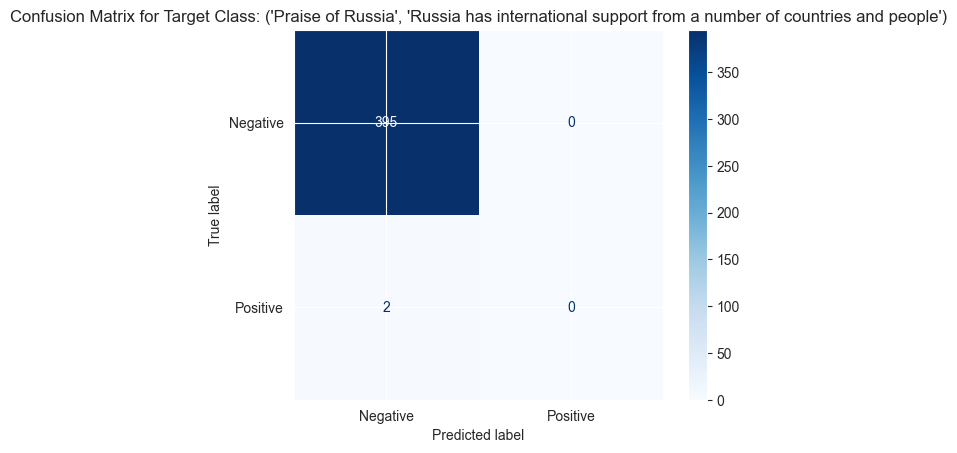

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

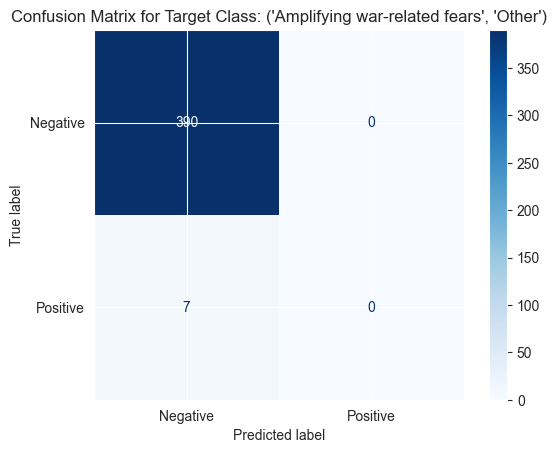

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

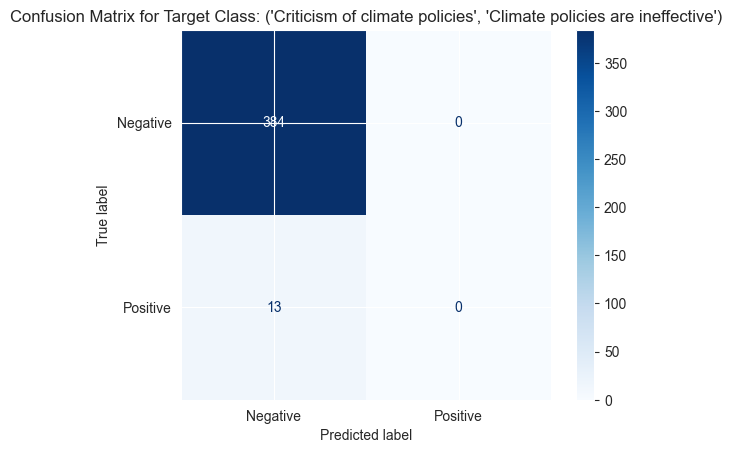

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

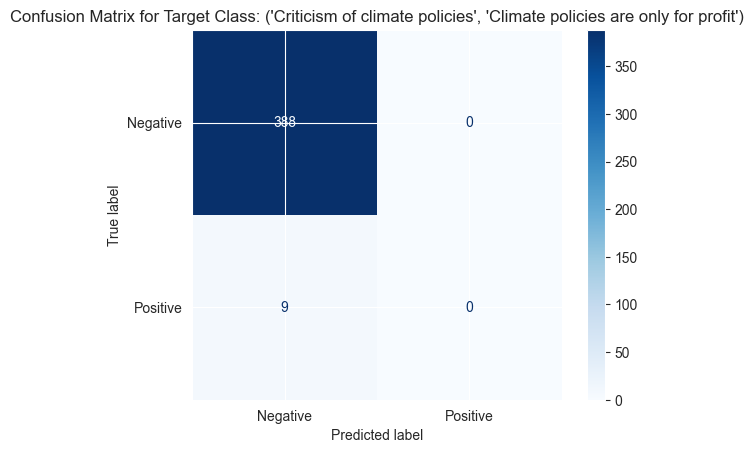

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

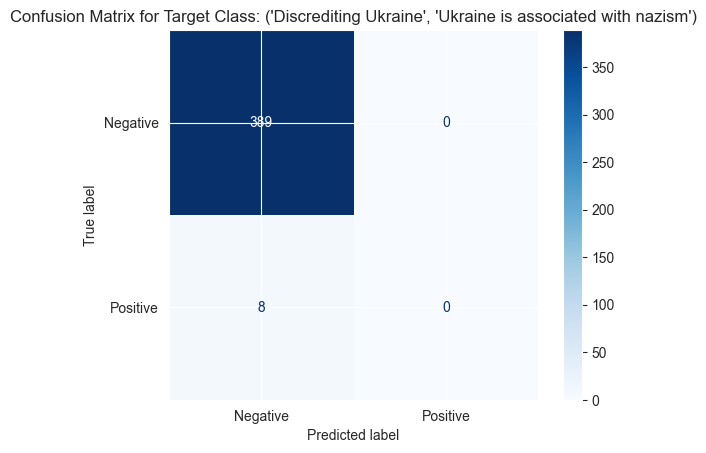

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

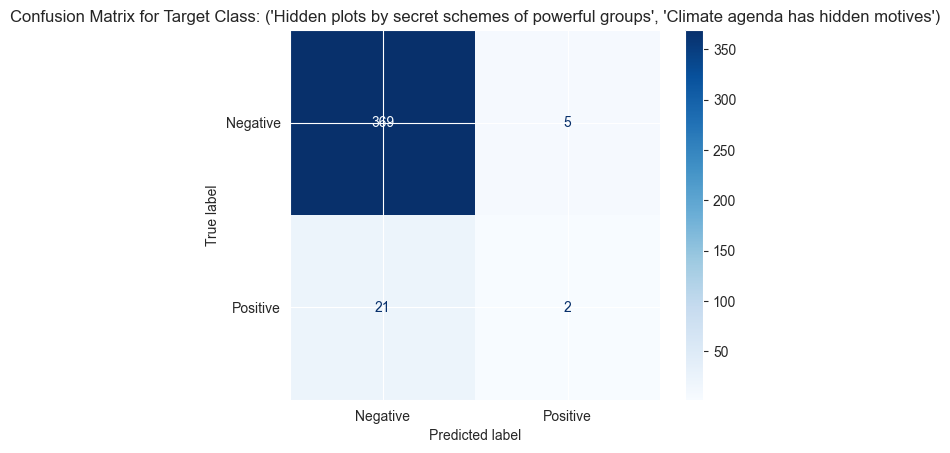

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

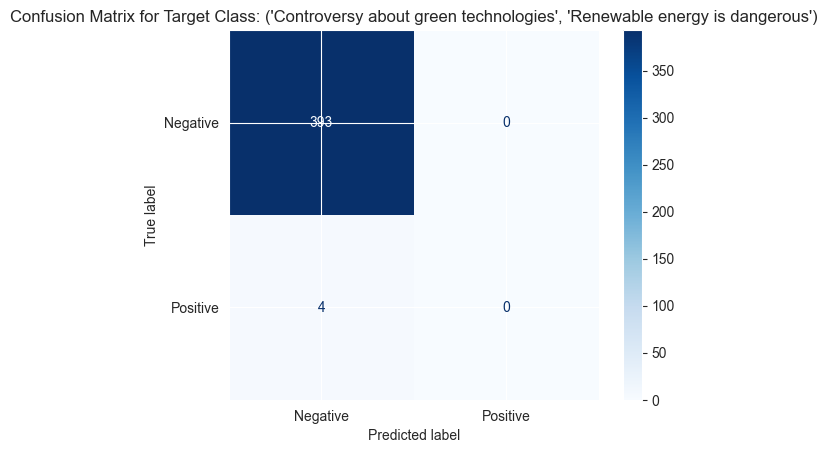

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

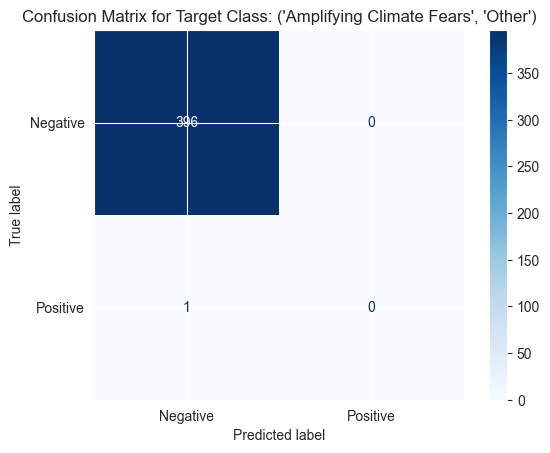

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

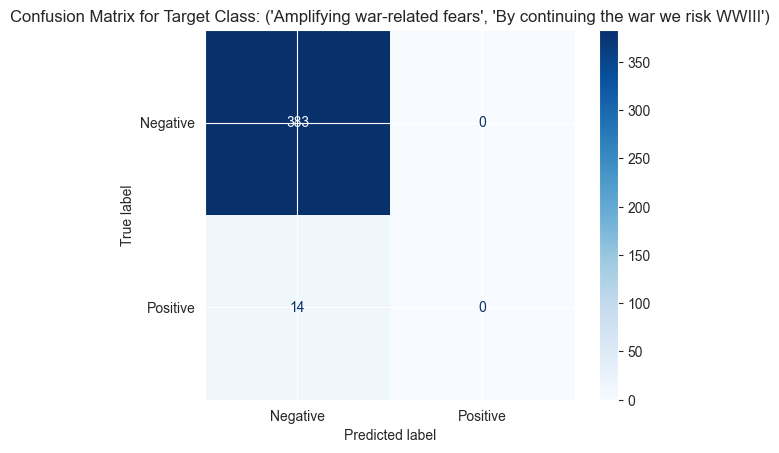

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

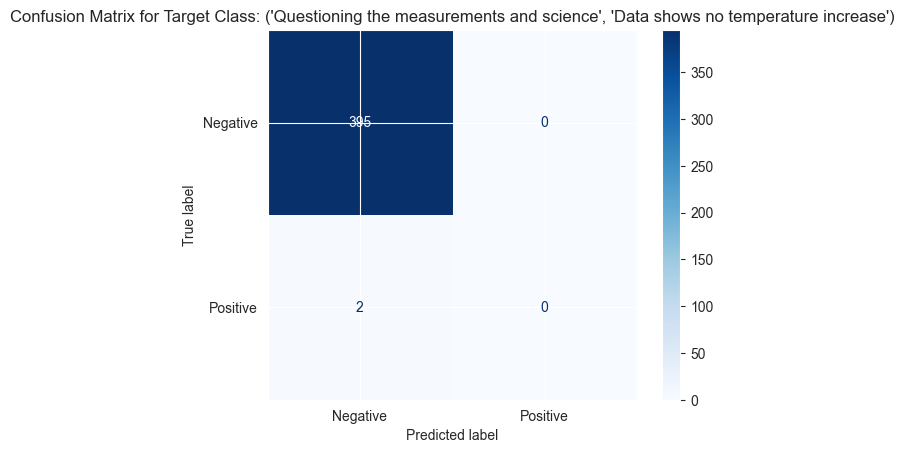

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

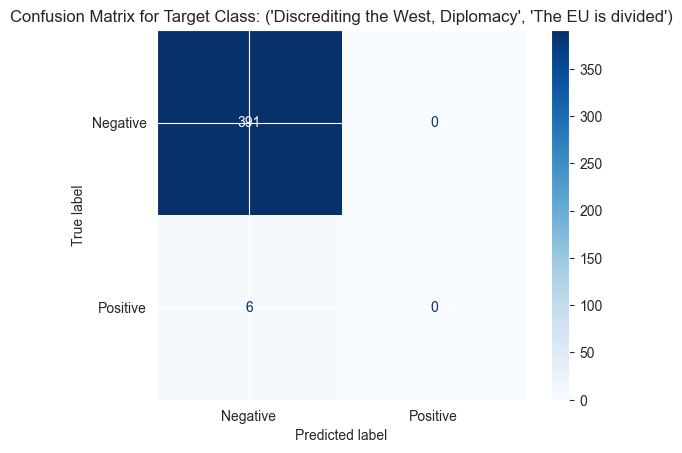

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

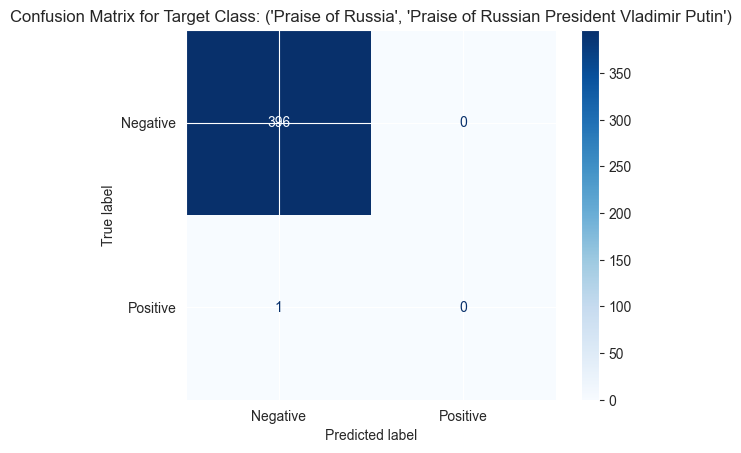

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

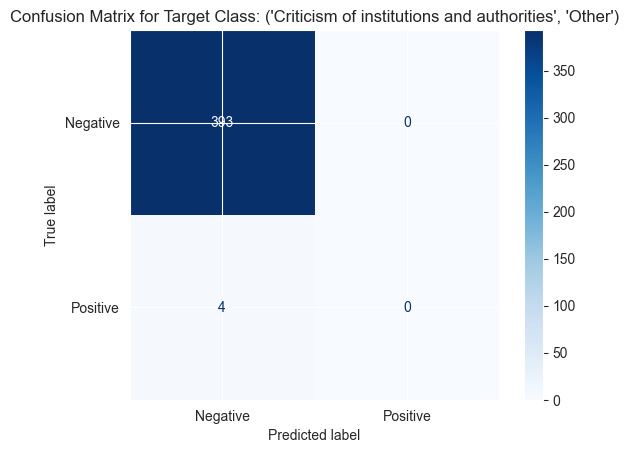

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

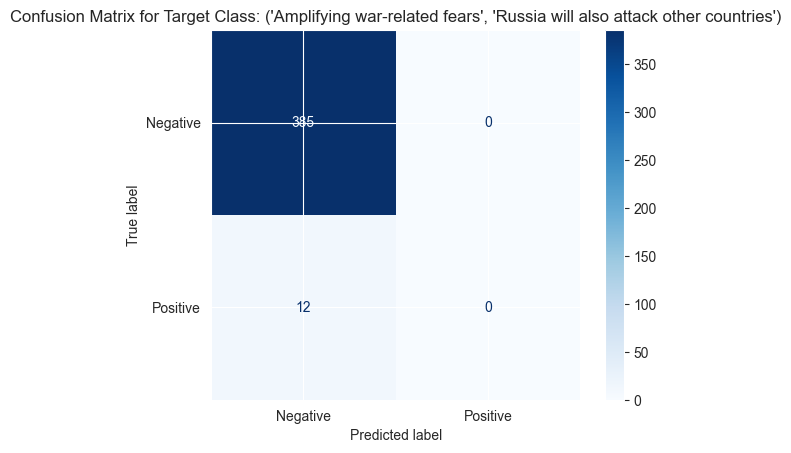

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

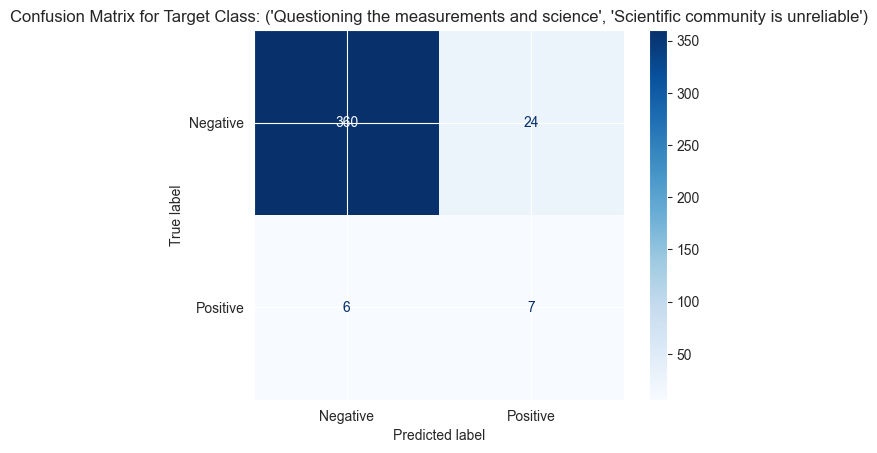

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

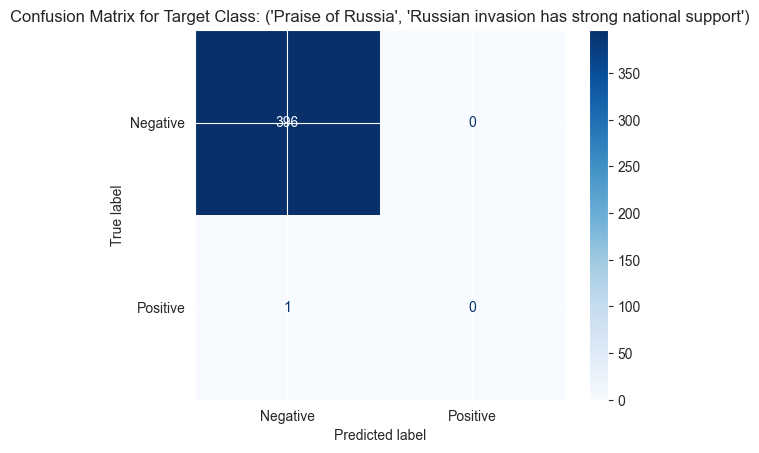

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

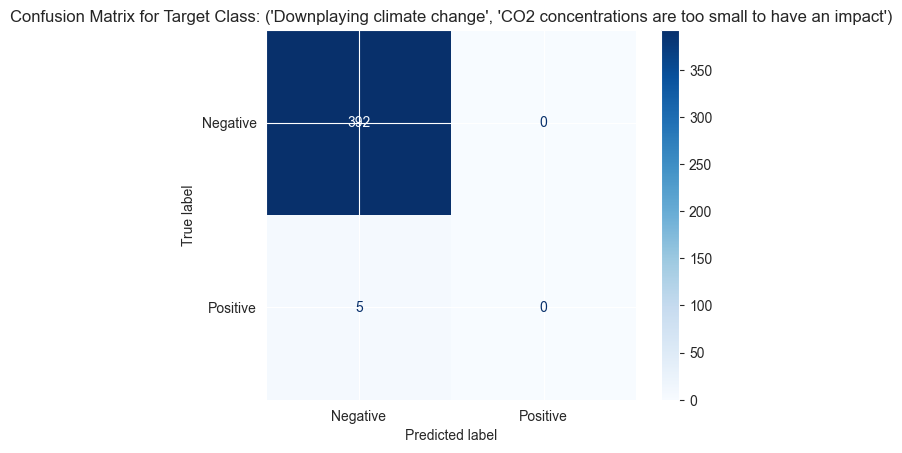

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

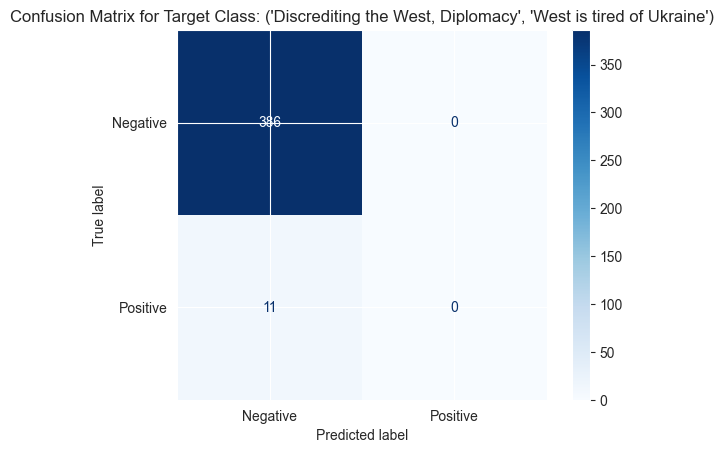

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

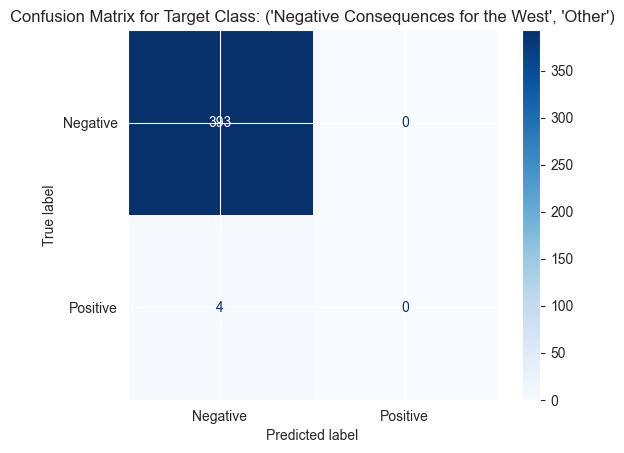

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

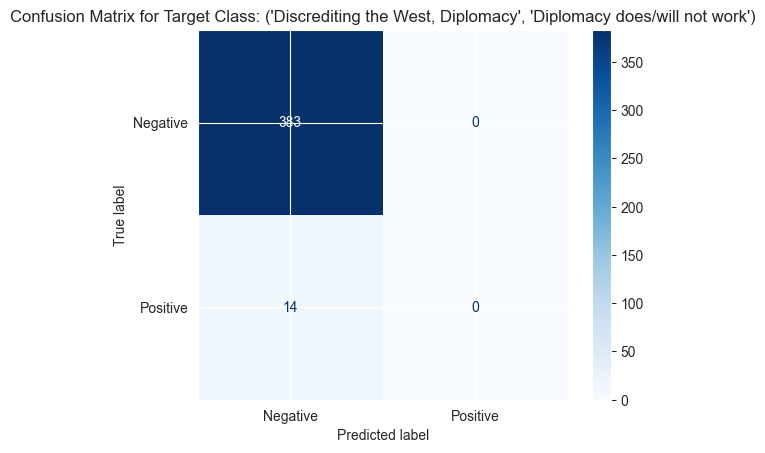

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

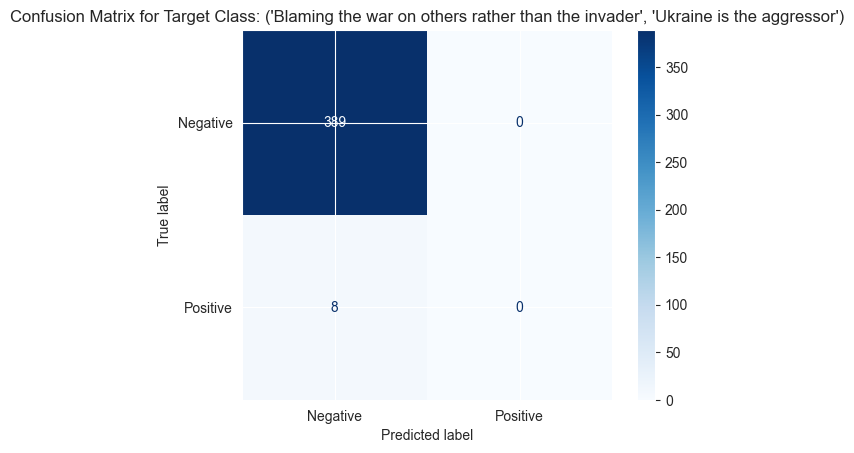

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

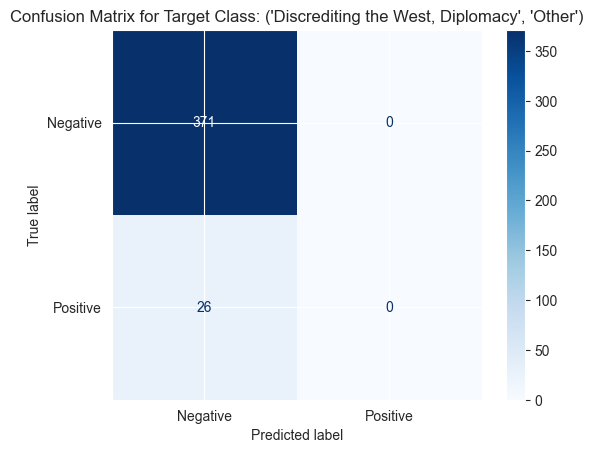

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

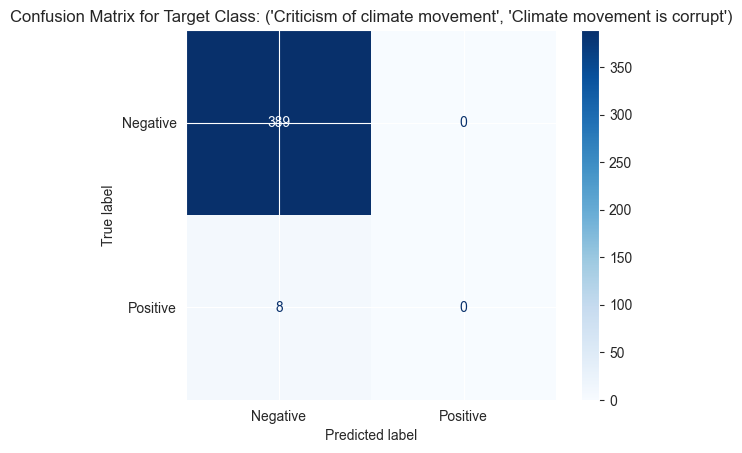

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

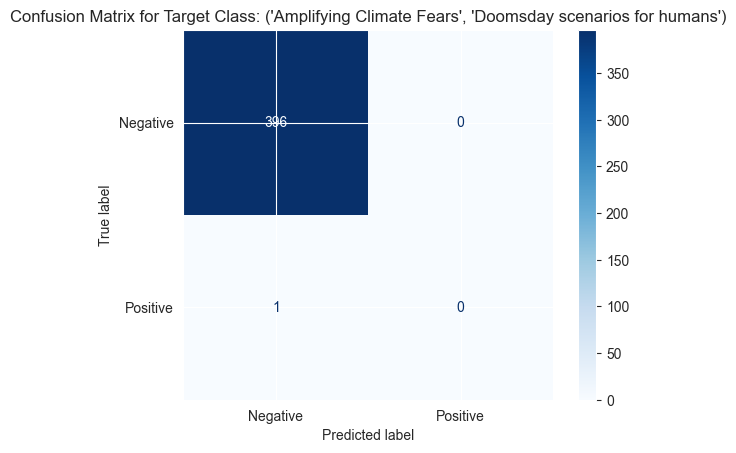

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

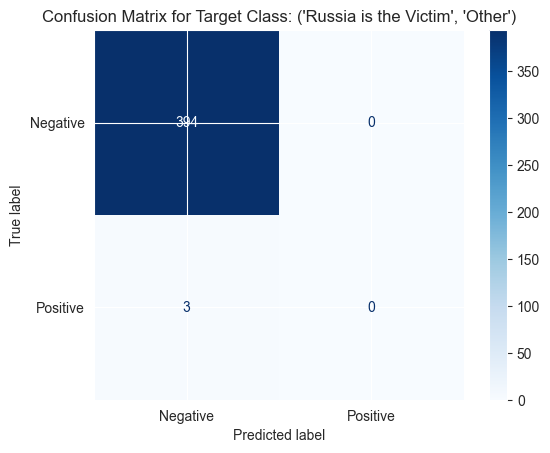

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

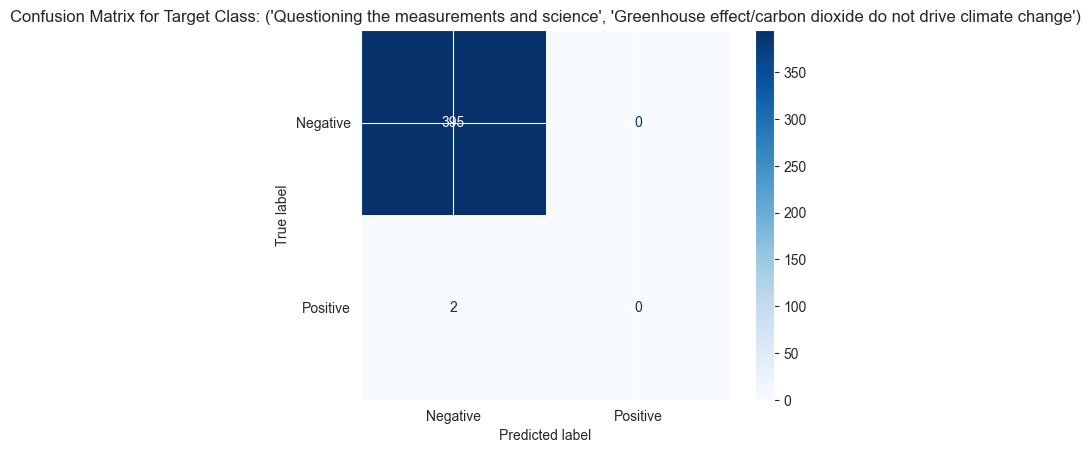

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

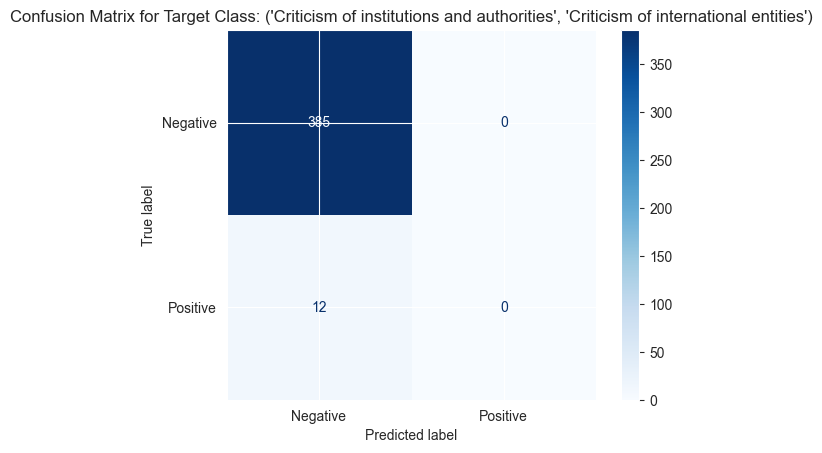

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

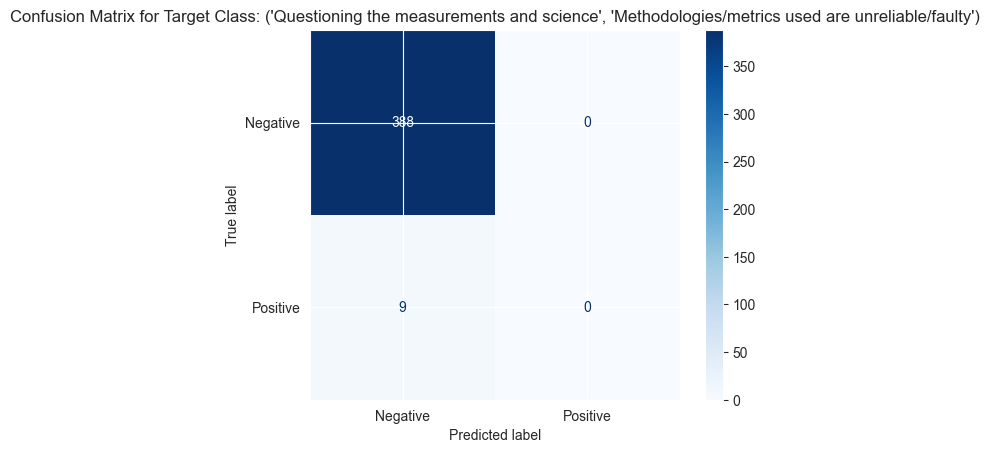

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

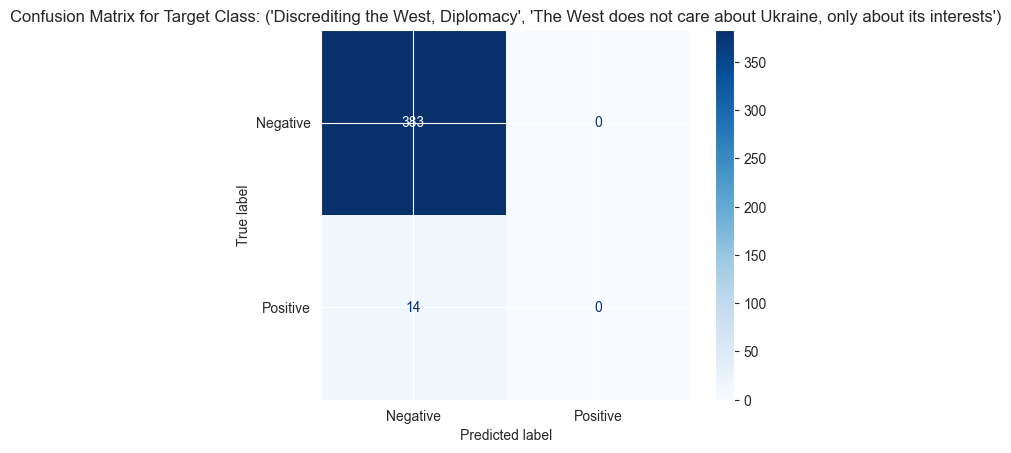

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

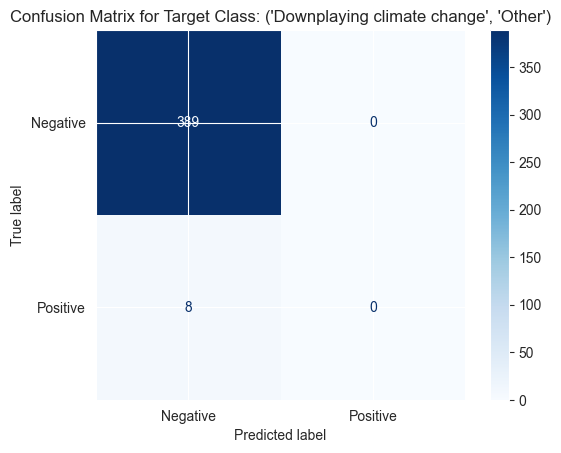

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

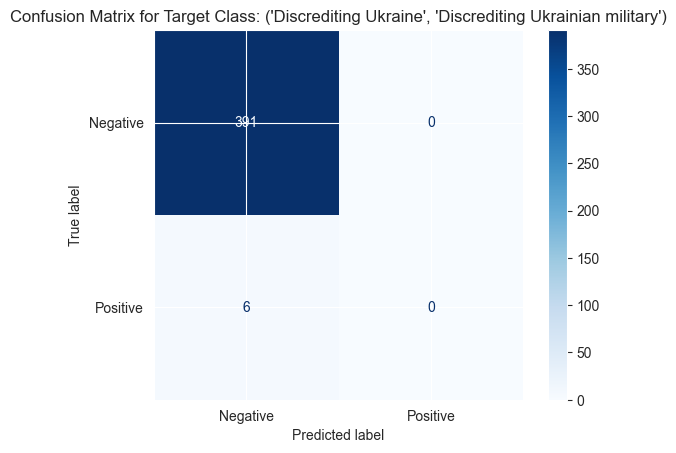

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

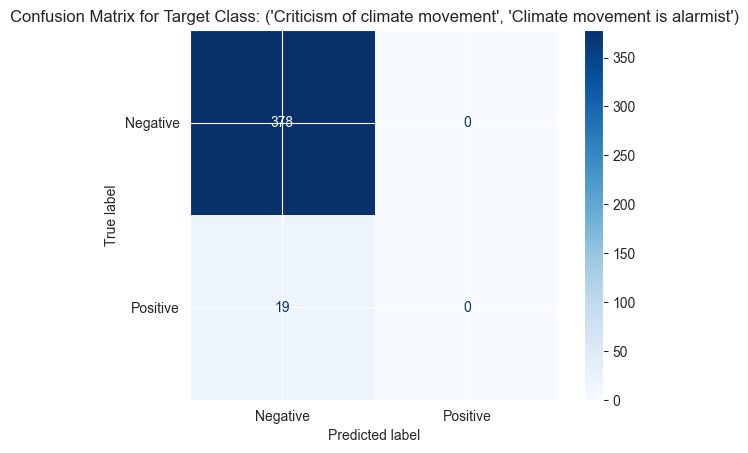

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

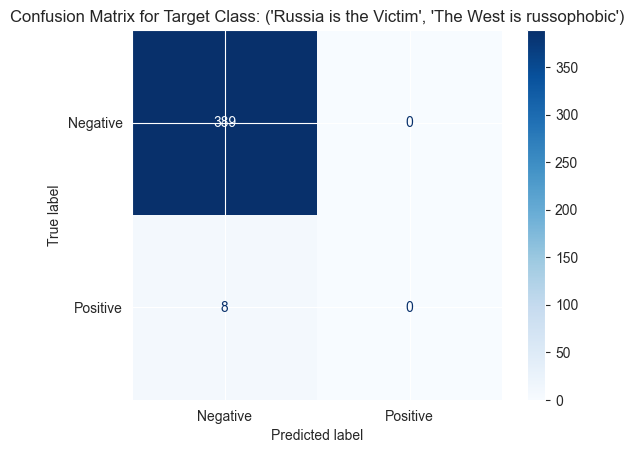

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

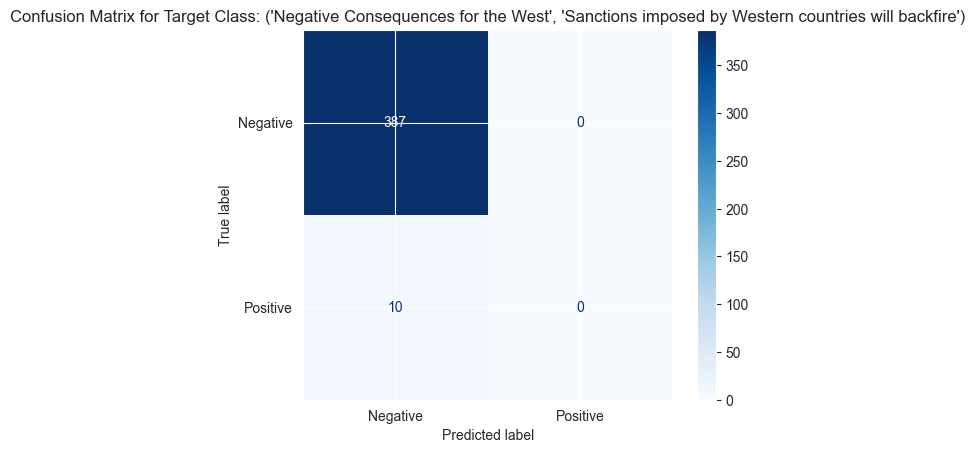

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

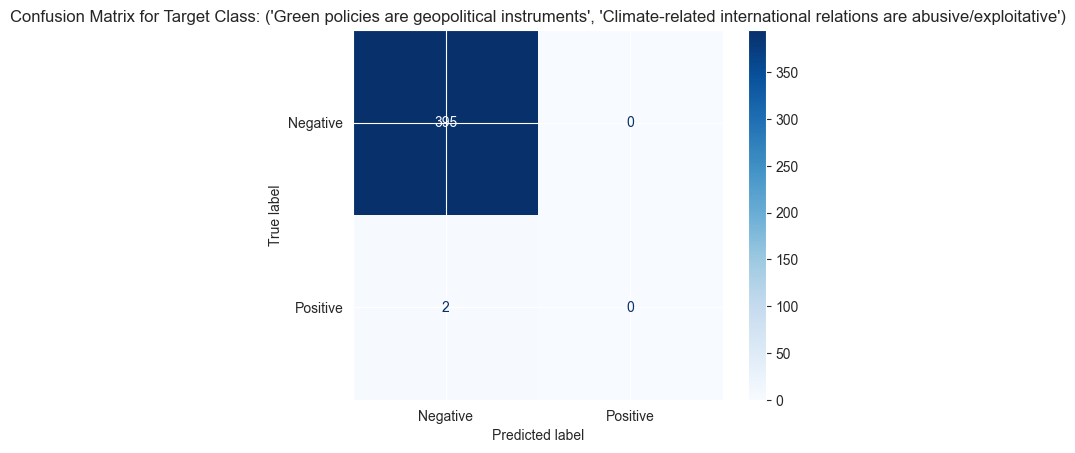

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

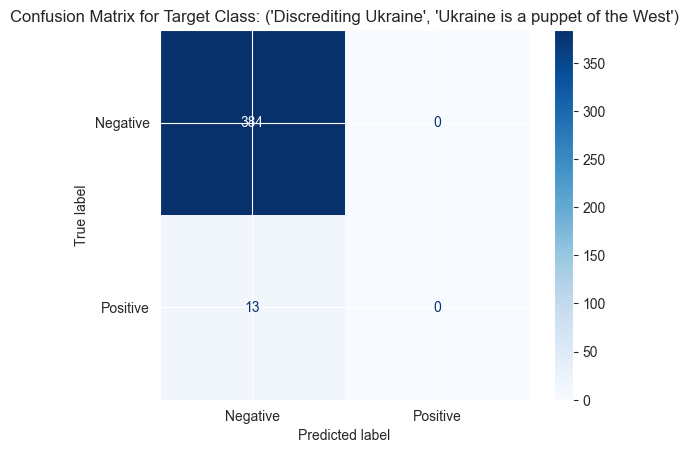

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

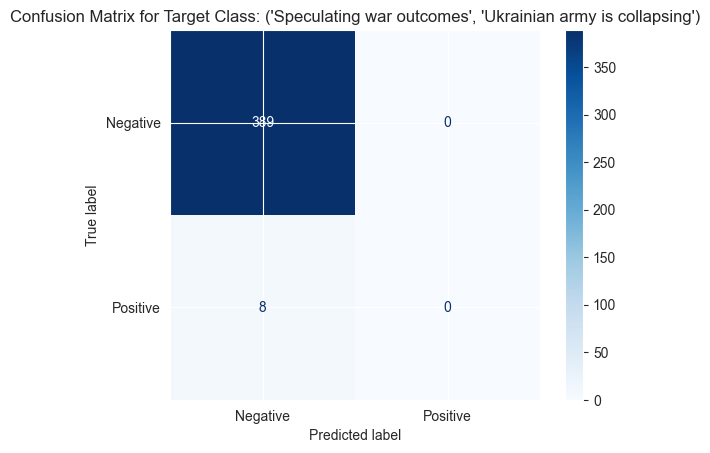

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

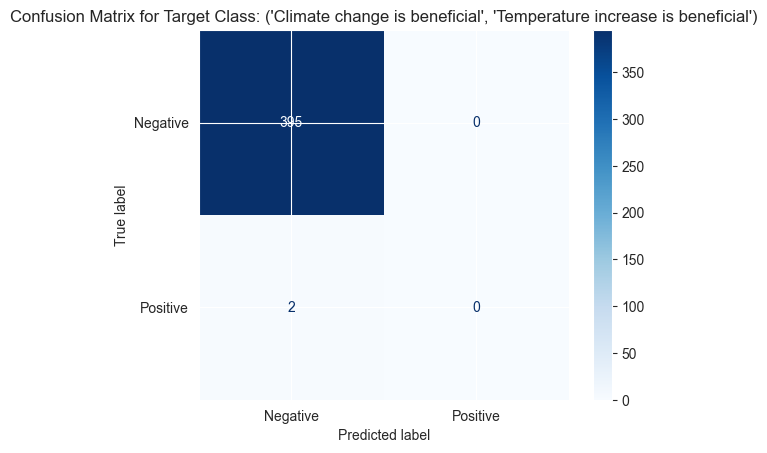

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

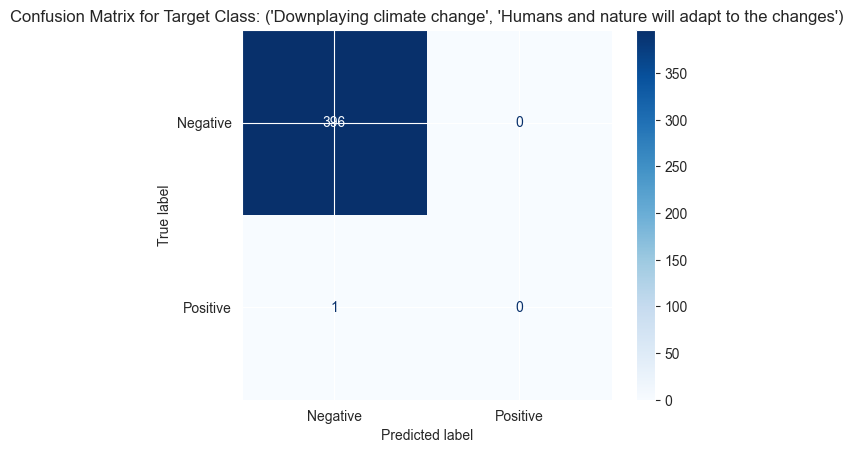

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

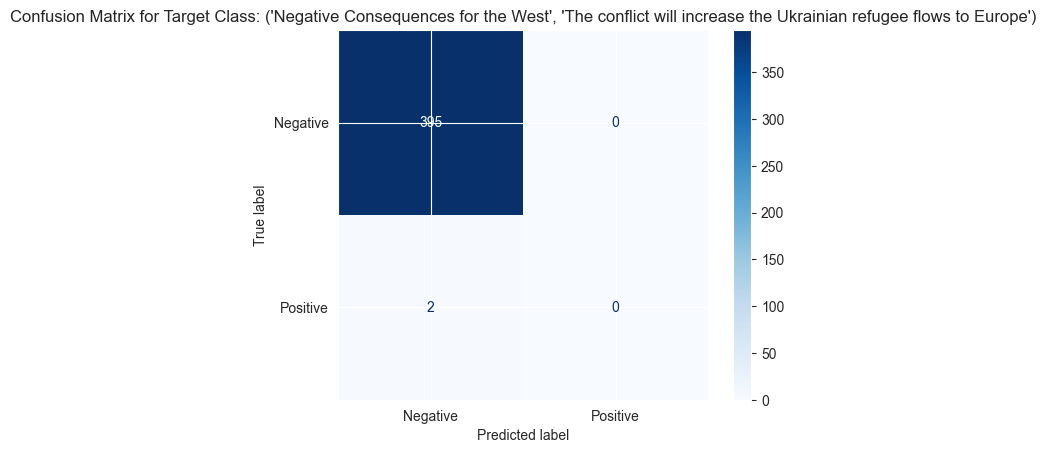

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

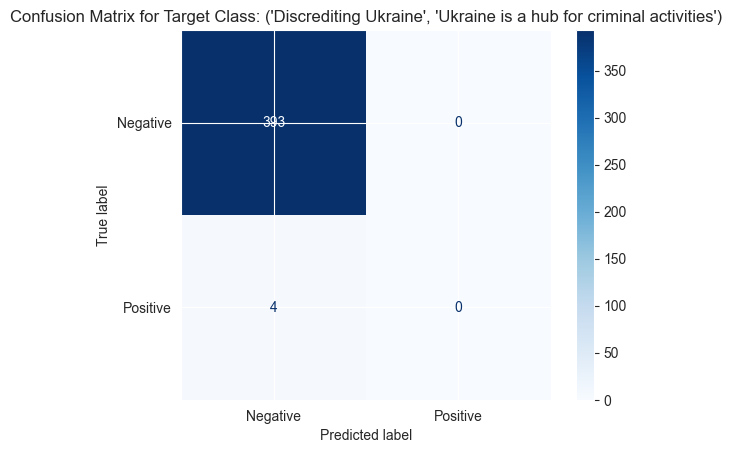

C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['True Positives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['False Negatives'] = english_dataset.apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1690067518.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

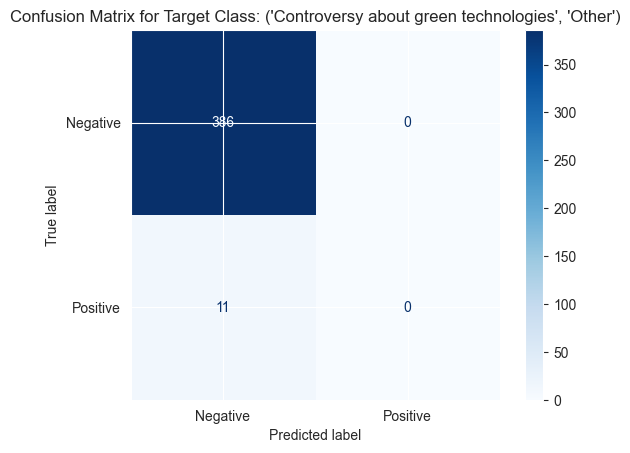

Class Summary (English Texts):
                                         target_class  TP  FN  FP   TN
0   (Praise of Russia, Russia is a guarantor of pe...   0   3   0  394
1   (Climate change is beneficial, CO2 is beneficial)   0   3   0  394
2   (Controversy about green technologies, Renewab...   0  10   0  387
3                           (Praise of Russia, Other)   0   2   0  395
4   (Speculating war outcomes, Russian army is col...   0   4   0  393
..                                                ...  ..  ..  ..  ...
78  (Climate change is beneficial, Temperature inc...   0   2   0  395
79  (Downplaying climate change, Humans and nature...   0   1   0  396
80  (Negative Consequences for the West, The confl...   0   2   0  395
81  (Discrediting Ukraine, Ukraine is a hub for cr...   0   4   0  393
82      (Controversy about green technologies, Other)   0  11   0  386

[83 rows x 5 columns]


In [19]:
english_dataset = dataset[dataset["language"] == "EN"]
russian_dataset = dataset[dataset["language"] == "RU"]

# Getting all unique classes from "narrative_subnarrative_pairs" and "predicted_narrative"
all_classes = set()

# Extracting unique classes
english_dataset["narrative_subnarrative_pairs"].apply(
    lambda pairs: all_classes.update(
        tuple((d["narrative"], d["subnarrative"]) for d in eval(pairs))
    )
)
english_dataset["predicted_narrative"].apply(
    lambda pred: all_classes.add(tuple(eval(pred).values()))
)

class_summary_list = []

for target_class in all_classes:
    english_dataset["True Positives"] = english_dataset.apply(
        lambda row: target_class
        in [
            (d["narrative"], d["subnarrative"])
            for d in eval(row["narrative_subnarrative_pairs"])
        ]
        and tuple(eval(row["predicted_narrative"]).values()) == target_class,
        axis=1,
    )
    english_dataset["False Negatives"] = english_dataset.apply(
        lambda row: target_class
        in [
            (d["narrative"], d["subnarrative"])
            for d in eval(row["narrative_subnarrative_pairs"])
        ]
        and tuple(eval(row["predicted_narrative"]).values()) != target_class,
        axis=1,
    )
    english_dataset["False Positives"] = english_dataset.apply(
        lambda row: target_class
        not in [
            (d["narrative"], d["subnarrative"])
            for d in eval(row["narrative_subnarrative_pairs"])
        ]
        and tuple(eval(row["predicted_narrative"]).values()) == target_class,
        axis=1,
    )
    english_dataset["True Negatives"] = english_dataset.apply(
        lambda row: target_class
        not in [
            (d["narrative"], d["subnarrative"])
            for d in eval(row["narrative_subnarrative_pairs"])
        ]
        and tuple(eval(row["predicted_narrative"]).values()) != target_class,
        axis=1,
    )

    # Summing confusion matrix for current target
    class_summary_list.append(
        {
            "target_class": target_class,
            "TP": english_dataset["True Positives"].sum(),
            "FN": english_dataset["False Negatives"].sum(),
            "FP": english_dataset["False Positives"].sum(),
            "TN": english_dataset["True Negatives"].sum(),
        }
    )
    y_true = (
        english_dataset["narrative_subnarrative_pairs"]
        .apply(
            lambda pairs: target_class
            in [(d["narrative"], d["subnarrative"]) for d in eval(pairs)]
        )
        .astype(int)
    )
    y_pred = (
        english_dataset["predicted_narrative"]
        .apply(lambda pred: tuple(eval(pred).values()) == target_class)
        .astype(int)
    )

    # Creating CMs
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Negative", "Positive"]
    )
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for Target Class: {target_class}")
    plt.show()

We will choose class *narrative: Hidden plots by secret schemes of powerful groups, subnarrative: Climate agenda has hidden motives* for the qualitative analysis of english.

We will print out the needed columns of the texts that were predicted with a different label, although they had the label mentioned above. Also, we will print news articles where the model predicted the label correctly to inspect those outputs.

In [42]:
import ast

# Parse temp_narrative and predicted_narrative if they are strings
english_dataset["temp_narrative"] = english_dataset["temp_narrative"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

english_dataset["predicted_narrative"] = english_dataset["predicted_narrative"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


def normalize_dict(d):
    """Normalize a dictionary by sorting its keys."""
    return {k: d[k] for k in sorted(d)}


# Normalize analyzing_class
analyzing_class_normalized = normalize_dict(analyzing_class)

# Normalize temp_narrative and predicted_narrative
english_dataset["temp_narrative"] = english_dataset["temp_narrative"].apply(
    normalize_dict
)
english_dataset["predicted_narrative"] = english_dataset["predicted_narrative"].apply(
    normalize_dict
)

# Filtering True Positives
true_positive_english = english_dataset[
    (english_dataset["predicted_narrative"] == analyzing_class_normalized)
    & (english_dataset["temp_narrative"] == analyzing_class_normalized)
]

# Filtering False Negatives
false_negatives_english = english_dataset[
    (english_dataset["predicted_narrative"] != analyzing_class_normalized)
    & (english_dataset["temp_narrative"] == analyzing_class_normalized)
]

# Output results
print("True Positive indexes:")
print(true_positive_english.index.tolist())

print("\nFalse Negative indexes:")
print(false_negatives_english.index.tolist())

True Positive indexes:
[153]

False Negative indexes:
[66, 86, 91, 104, 293, 337]


C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1315145251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['temp_narrative'] = english_dataset['temp_narrative'].apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1315145251.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_dataset['predicted_narrative'] = english_dataset['predicted_narrative'].apply(
C:\Users\asus9\AppData\Local\Temp\ipykernel_8448\1315145251.py:20: SettingWithCopyWarning: 
A value is trying to be set on a

### True positive content:

In [43]:
print(true_positive_english.loc[153, "content"])

Biden regime's war on your appliances just widened with new attack on dishwashers, under guise of 'climate change' 

 Under the guise of 'fighting climate change,' the regime has now proposed new regulations that target some of the most commonly used household appliances, including dishwashers. According to Fox Business, the Department of Energy has proposed new rules that would reduce the current limits for water and energy use in dishwashers.

The proposed rules would limit dishwashers to using 3.2 gallons of water per cycle, significantly lower than the current limit of 5 gallons, and manufacturers would need to reduce their products’ energy consumption by almost 30 percent. Even though most dishwashers available on the market already meet or exceed the current federal standards, the proposed rules have left some questioning why the Biden administration is focusing on such regulations rather than other priorities.

“Dishwashers are not the only appliances Biden’s DOE has set its sig

Reading through this news article, we can see that there are two sentences in the beginning, where the author already starts to point to the direction, the new regulations being met "under the guise of fighting 'climate change'". He also says that most dishwasers that are sold today already align with the planned regulations and that the government should focus on other topics, the meaning of the direction the text is focused to gets clear. Those two cases have probably led to the correct assumption, that there are hidden plots by powerful groups (the government).
Having the text part "under the guise" likely led to the assumption that the climate agenda has hidden motives.

We can assume that the texts the model was trained with contained words like "hidden", "climate agenda" or "regime", because those words are all contained in the news article that was predicted correctly by the model. Those words were also used to hold information which likely led the label human classify the text under that label.

Further, the sentence, that "Critics have also poked major holes in the regime´s claim [...]" also could contribute to the fact that the model predicted especially this narrative-subnarrative pair, as the governments attempt to reduce energy consumption is getting criticized.



### False negative content:

In [44]:
print(false_negatives_english.loc[104, "content"])

BBB, Trump, military exercises, predictive programming and more. 


The Boeren Burger Beweging/Farmers Citizens Movement sounds good for farmers but this party is a WEF sellout! It is NOT good news that they won the elections. Caroline van der Plas founded this movement in 2019 and is going along with the nitrogen hoax, climate change lies and biodiversity made up bullshit in order to buy up most of the farmers. She only looks at the financial side, but we all know, no farmers, no food. We are a major exporter of our products so this has an effect worldwide.

Trump is NOT on our side for those who forgot his operation warpspeed with the plan of military involvement. In his current campaign he even talks about so-called freedom cities. Do not be fooled, these are AI generated concentration camps!

Military presence is something they want us to get used to. It is not anti terrorism, it is anti citizens.

Satanism in plain sight everywhere. In our schools, in satanic performances, attacki

In [115]:
print(false_negatives_english.loc[293, "content"])

Globalist Oligarchs Wrap Up Their Conference With The Dumbest Claim Ever 

 A group of mostly unelected globalist oligarchs met in December and decided, for the third decade in a row, to stretch the truth about their efforts to fight “climate change” by cutting fossil fuel emissions.

Unelected representatives from almost 200 countries flew to Dubai in December (on their private jets) to discuss how us poors are ruining their planet by using gas stoves and the like, Reuters reported, using far more diplomatic terms. These “representatives” at Dubai’s COP28 summit decided to unite in putting an end to fossil fuels … literally the same thing they’ve said they wanted to do since the Kyoto Protocol of December 1997.

The Kyoto Protocol was one of the first annual “summits” held by unelected Bond villains who want to decide our fate. At the time, the countries present decided to cut fossil fuel use around the world, lest we be dead or drowning within a decade or two, which turned out to be 

In the first article, there are some sentences that indicate the topic *Climate Change* slightly. Especially the sentence saying "Caroline van der Plas founded [the movement]" and the following part about "nitrogen hoax", "climate change lies" and "[...] buy up most of the farmers" should lead the model to predict the actual label, as those words and sentences shall be likely been used in other news articles with that true label for training.

Nevertheless, the second part of the article starts getting religious with text parts like "Accept Jesus Christ as our saviour" or "Read the bible, fast and pray" or "Amen". Those words and especially this topic and tone of writing does not anything contribute to the true label. Thus, this drift off the climate change topic could lead the model to assume the text to belong toa different label, especially if there were some religious texts that were predicted with Other-Other or a different label, where religious topics would fit into the label.

The second article contains little Climate Change information throughout the whole text, which is understandable if one knows what kind of meetup was in Dubai and why influential people are joining it. Parts like "Globalist oligarchs met [...]" or "Unelected Bond villains who want to decide our fate." and "Mega Rich Elite [...]" tries to frame the politicians as a powerful group in a pejorative way.
Still, the model did not predict this news article as the true label. One reason for that could be, that the article is written in a sarcastic and pejorative way, which could lead the model to predict the label Other-Other, because the climate change content of the text is a bit hidden in political and social concepts that need to be understood.